<a href="https://colab.research.google.com/github/mille055/stanford_project/blob/dockerversion/app/notebooks/Stanford_CS231N.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
COLAB_FLAG = True   # whether running on colab or locally on computer

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
if COLAB_FLAG:
  %pip install pydicom==2.1.2
  %pip install monai seaborn sentence_transformers
  !git clone -b dockerversion 'https://github.com/mille055/stanford_project.git'
  

    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 53.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.5 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=11651f9074f33686b26a862b597618ef0267afc4ef1882c55702e2a05a28f891
  Stored in directory: /r

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import torchvision
import pydicom
import pickle
import glob
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

import seaborn as sns
from datetime import datetime

from sentence_transformers import SentenceTransformer

from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import copy
from pprint import pprint
from fastai.basics import delegates
from fastcore.parallel import parallel
from fastcore.utils import gt
from fastcore.foundation import L

from pydicom.dataset import Dataset as DcmDataset
from pydicom.tag import BaseTag as DcmTag
from pydicom.multival import MultiValue as DcmMultiValue
import sys
import importlib
import warnings
from google.colab import drive
warnings.filterwarnings("ignore")

In [5]:
#local imports
if COLAB_FLAG:
    sys.path.append('/content/stanford_project/app/scripts/')
    train_datafile = '/content/stanford_project/app/data/trainfiles.csv'
    val_datafile = '/content/stanford_project/app/data/valfiles.csv'
    test_datafile = '/content/stanford_project/app/data/testfiles.csv'
    
    drive.mount('/content/gdrive')

else: # running locally
    sys.path.append('/Users/cmm/Documents/GitHub/new/stanford_project/app/scripts/')
    #sys.path.append('/workspaces/stanford_project/app/scripts/')
    train_datafile = '../data/trainfiles.csv'
    val_datafile = '../data/valfiles.csv'
    test_datafile = '../data/testfiles.csv'


### local imports ###
from config import file_dict, feats, feats_to_keep, column_lists, RF_parameters, classes, model_paths
from config import abd_label_dict, val_list, train_val_split_percent, random_seed, data_transforms
from config import sentence_encoder, series_description_column
from utils import *

from cnn.cnn_dataset import ImgDataset
from cnn.cnn_inference import image_to_tensor, pixel_inference, test_pix_model, load_pixel_model, visualize_results
from cnn.cnn_model import *
from cnn.cnn_training import *
from cnn.cnn_data_loaders import get_data_loaders, data_transforms, data_transforms2

from model_container import ModelContainer



Mounted at /content/gdrive


In [6]:


train_df, val_df, test_df = create_datasets(train_datafile, val_datafile, test_datafile, '/volumes/cm7/Abdominal_MRI_dataset_split/', '/content/gdrive/MyDrive/WW_MRI_abd2/split/' )



In [7]:
sorted(val_df.label.unique())

[0, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 23, 25]

In [9]:
# Get the data loaders
batch_size = 16
train_loader, val_loader, test_loader, dataset_sizes = get_data_loaders(train_df, val_df, test_df, batch_size)
train_loader2, val_loader2, test_loader2, dataset_sizes2 = get_data_loaders(train_df, val_df, test_df, batch_size, data_tranforms=data_transforms2)
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataloaders2 = {'train': train_loader2, 'val': val_loader2, 'test': test_loader2}

In [10]:
# Different combinations to evaluate
models = [CustomResNet50, CustomResNet50b, CustomDenseNet]
loss_funcs = [nn.CrossEntropyLoss, FocalLoss]
loaders = [dataloaders, dataloaders2]
optimizers = ['SGD', 'Adam']
optim_dict = {
    'SGD': {
        'class': torch.optim.SGD,
        'params': {'lr': 0.001, 'momentum': 0.9}
    },
    'Adam': {
        'class': torch.optim.Adam,
        'params': {'lr': 0.001, 'betas': (0.9, 0.999)}
    }
}



Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f0948aa6440>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f0941499d20>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f0941562ce0>}, SGD, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.9935 Acc: 0.4222
val Loss: 1.3086 Acc: 0.6299

Epoch 1/14
----------
train Loss: 0.9634 Acc: 0.7341
val Loss: 0.8580 Acc: 0.7401

Epoch 2/14
----------
train Loss: 0.5985 Acc: 0.8283
val Loss: 0.6985 Acc: 0.7825

Epoch 3/14
----------
train Loss: 0.3743 Acc: 0.8999
val Loss: 0.6162 Acc: 0.7966

Epoch 4/14
----------
train Loss: 0.2789 Acc: 0.9306
val Loss: 0.5735 Acc: 0.8079

Epoch 5/14
----------
train Loss: 0.1841 Acc: 0.9635
val Loss: 0.6154 Acc: 0.7966

Epoch 6/14
----------
train Loss: 0.1207 Acc: 0.9825
val Loss: 0.5970 Acc: 0.8220

Epoch 7/14
----------
train Loss: 0.0872 Acc: 0.9898
val Loss: 0.5583 Acc: 0.8390

Epoch 8/14
----------
train Loss: 0.0793 Acc: 0.9920
val

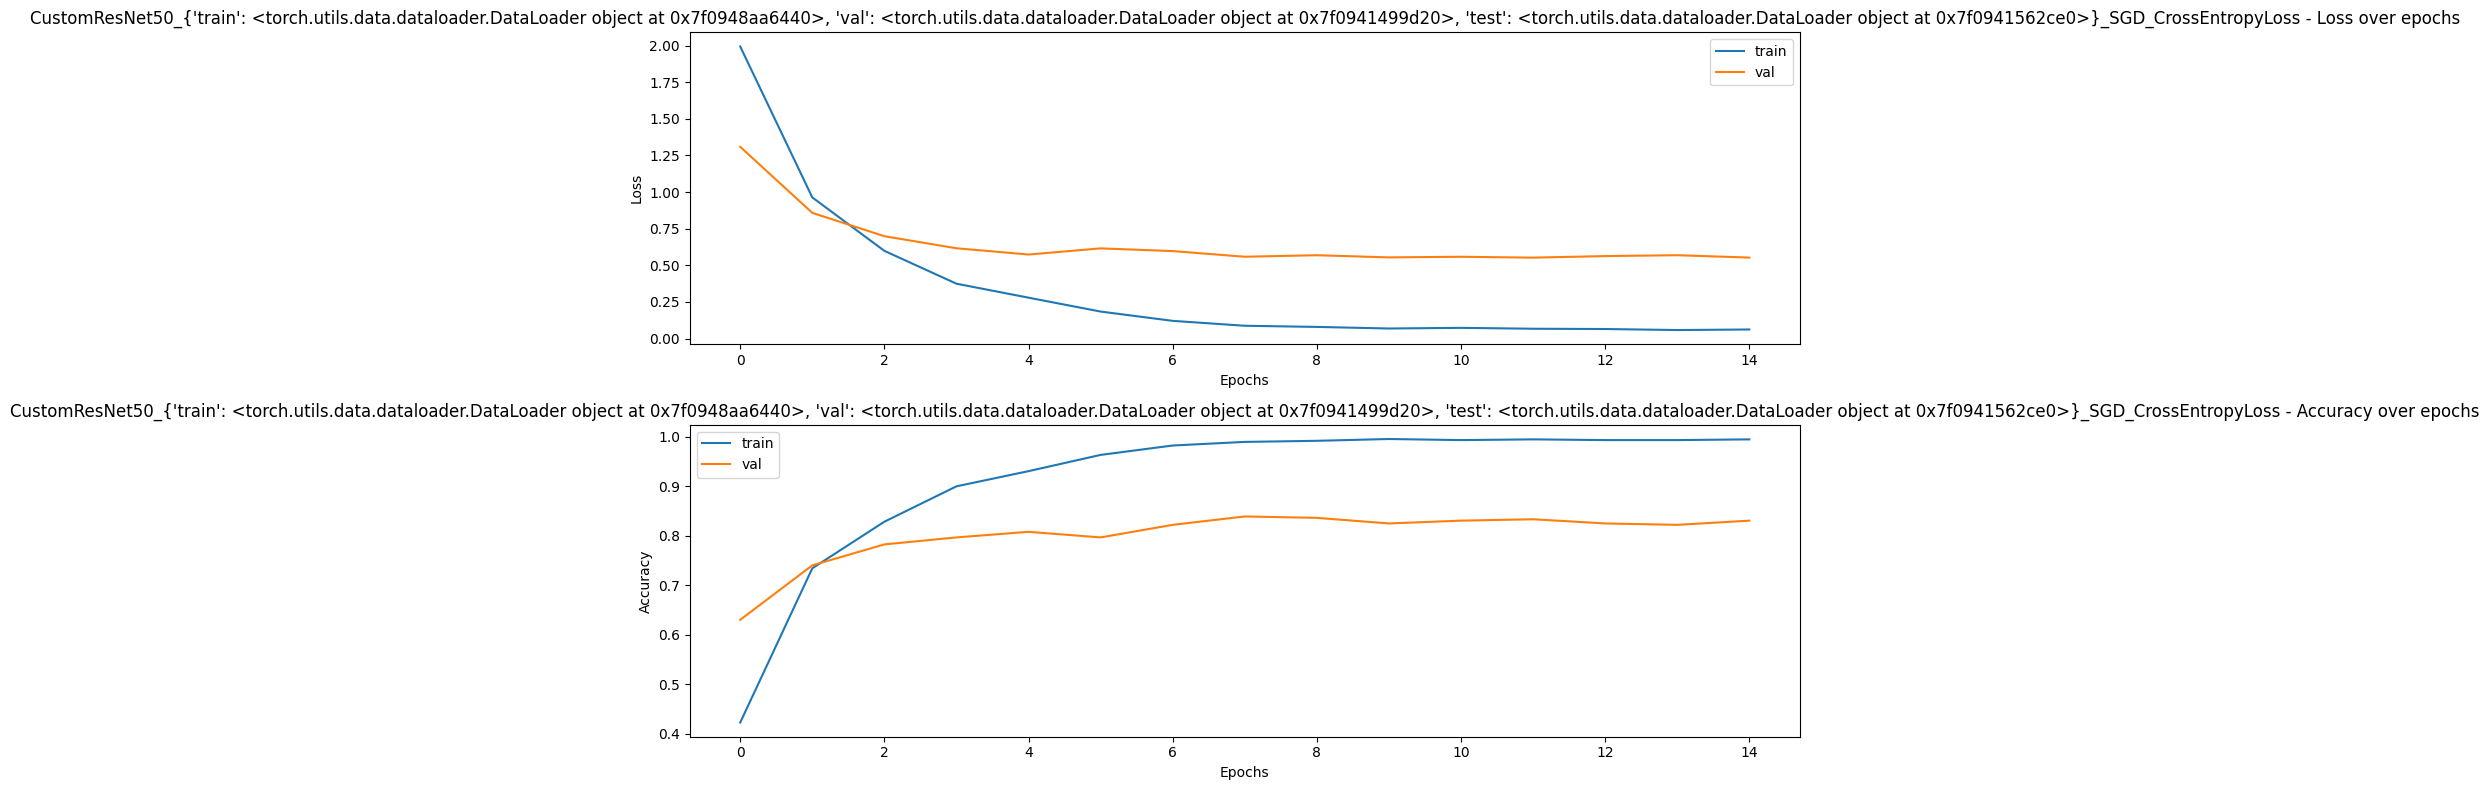


Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f0948aa6440>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f0941499d20>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f0941562ce0>}, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 1.4867 Acc: 0.4522
val Loss: 0.7968 Acc: 0.6299

Epoch 1/14
----------
train Loss: 0.5106 Acc: 0.7648
val Loss: 0.5220 Acc: 0.7599

Epoch 2/14
----------
train Loss: 0.2787 Acc: 0.8598
val Loss: 0.4228 Acc: 0.7768

Epoch 3/14
----------
train Loss: 0.1683 Acc: 0.9167
val Loss: 0.4216 Acc: 0.7910

Epoch 4/14
----------
train Loss: 0.0964 Acc: 0.9569
val Loss: 0.3975 Acc: 0.8023

Epoch 5/14
----------
train Loss: 0.0700 Acc: 0.9649
val Loss: 0.3751 Acc: 0.8051

Epoch 6/14
----------
train Loss: 0.0462 Acc: 0.9810
val Loss: 0.3959 Acc: 0.8136

Epoch 7/14
----------
train Loss: 0.0337 Acc: 0.9898
val Loss: 0.3780 Acc: 0.8305

Epoch 8/14
----------
train Loss: 0.0276 Acc: 0.9927
val Loss: 

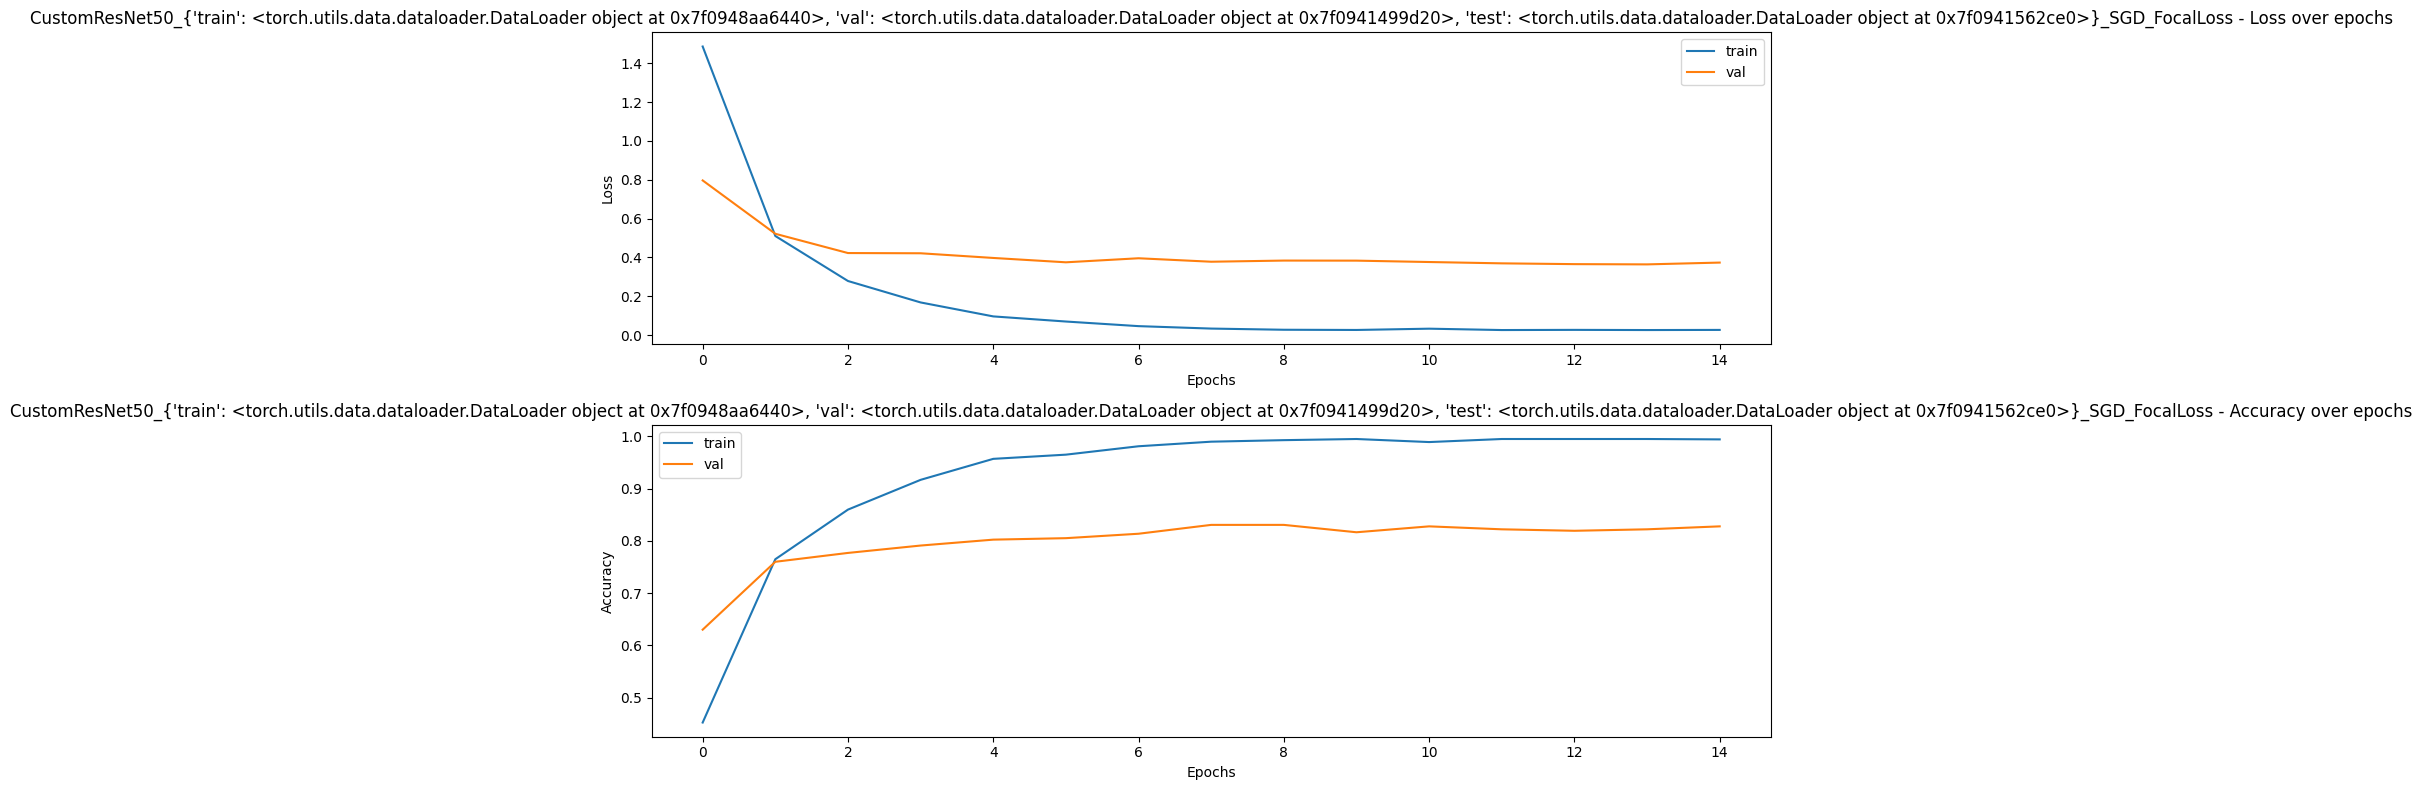


Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f0948aa6440>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f0941499d20>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f0941562ce0>}, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.6570 Acc: 0.4806
val Loss: 2.4405 Acc: 0.4209

Epoch 1/14
----------
train Loss: 1.1992 Acc: 0.6092
val Loss: 1.7774 Acc: 0.4548

Epoch 2/14
----------
train Loss: 0.9319 Acc: 0.6896
val Loss: 1.3193 Acc: 0.6328

Epoch 3/14
----------
train Loss: 0.8331 Acc: 0.7239
val Loss: 3.0190 Acc: 0.5085

Epoch 4/14
----------
train Loss: 0.6656 Acc: 0.7831
val Loss: 1.2799 Acc: 0.6808

Epoch 5/14
----------
train Loss: 0.5548 Acc: 0.8130
val Loss: 0.9540 Acc: 0.6864

Epoch 6/14
----------
train Loss: 0.5092 Acc: 0.8232
val Loss: 1.3901 Acc: 0.6243

Epoch 7/14
----------
train Loss: 0.3173 Acc: 0.8977
val Loss: 0.7289 Acc: 0.7966

Epoch 8/14
----------
train Loss: 0.1887 Acc: 0.9423
va

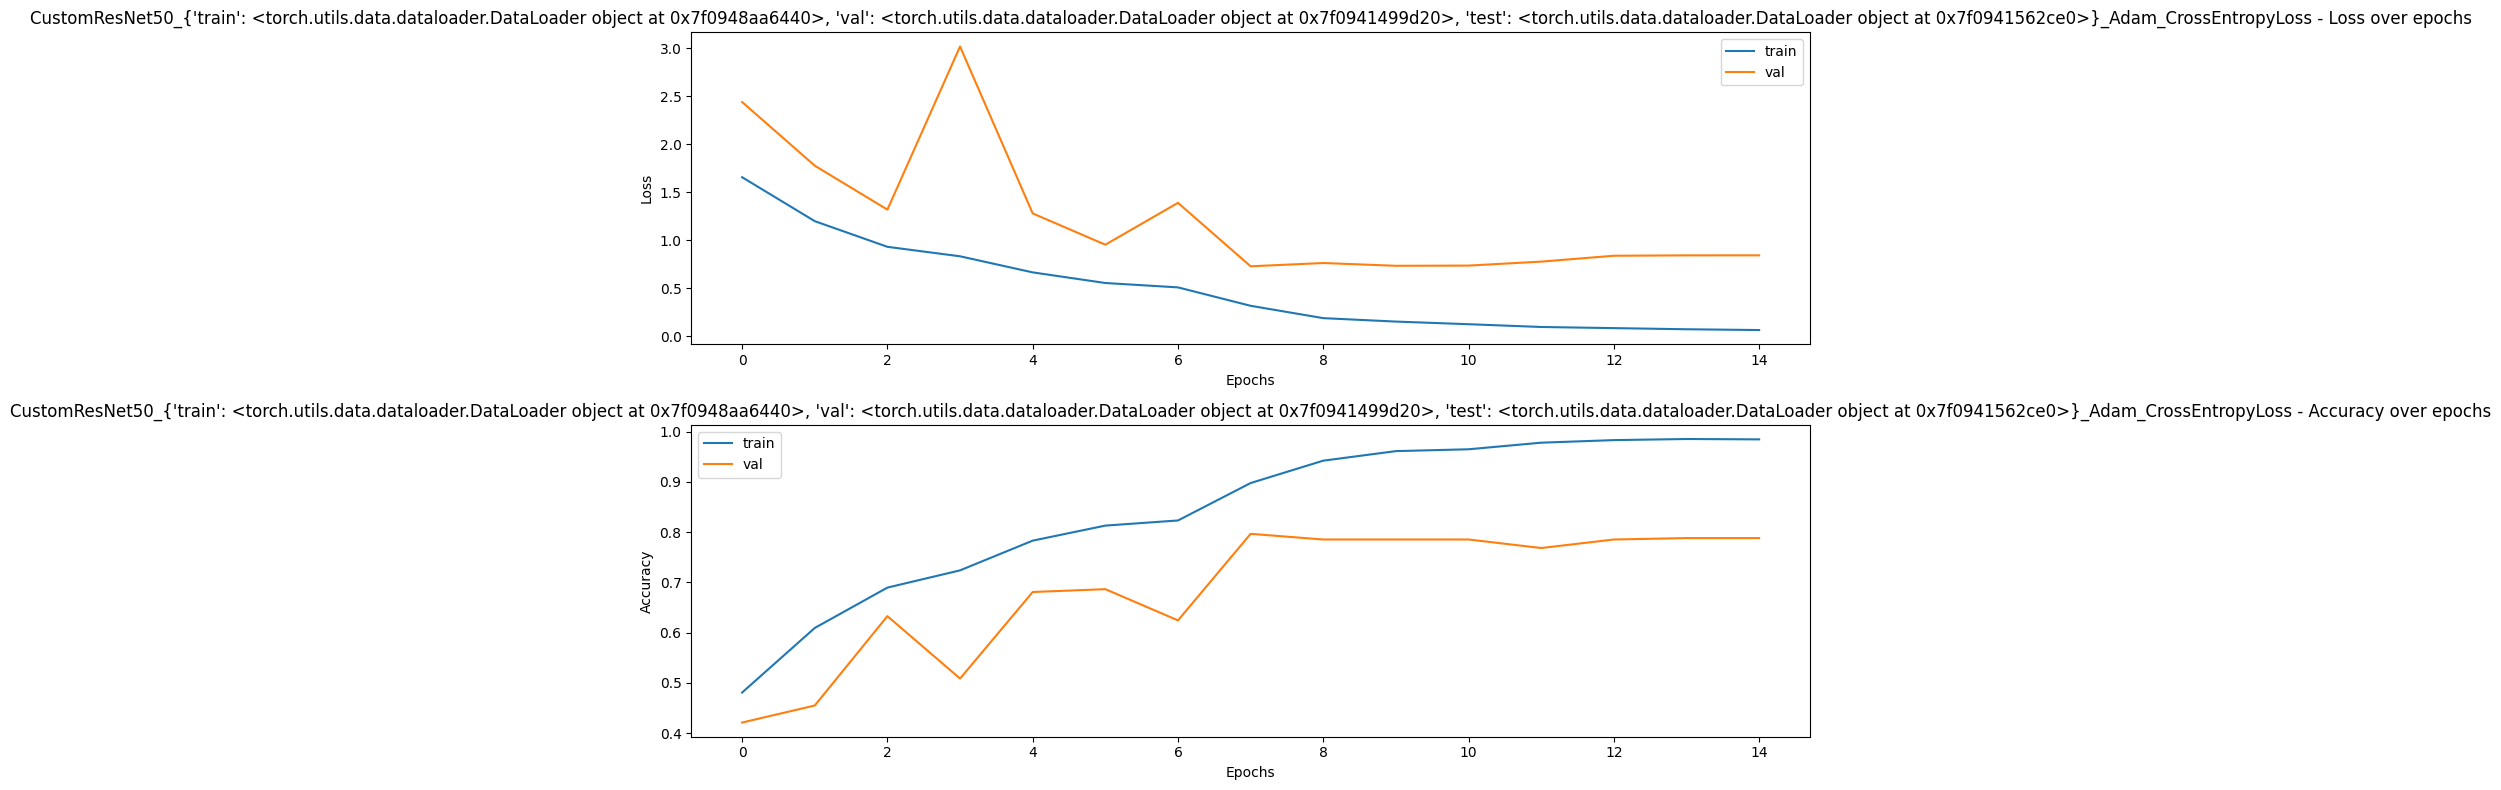


Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f0948aa6440>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f0941499d20>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f0941562ce0>}, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.2495 Acc: 0.4719
val Loss: 4.4562 Acc: 0.3249

Epoch 1/14
----------
train Loss: 0.8538 Acc: 0.5727
val Loss: 1.5365 Acc: 0.4350

Epoch 2/14
----------
train Loss: 0.6461 Acc: 0.6589
val Loss: 1.2884 Acc: 0.5339

Epoch 3/14
----------
train Loss: 0.5934 Acc: 0.6874
val Loss: 0.8228 Acc: 0.5904

Epoch 4/14
----------
train Loss: 0.4897 Acc: 0.7042
val Loss: 0.8693 Acc: 0.6384

Epoch 5/14
----------
train Loss: 0.4593 Acc: 0.7290
val Loss: 1.2844 Acc: 0.5452

Epoch 6/14
----------
train Loss: 0.3779 Acc: 0.7655
val Loss: 1.1493 Acc: 0.6130

Epoch 7/14
----------
train Loss: 0.2284 Acc: 0.8561
val Loss: 0.5116 Acc: 0.7514

Epoch 8/14
----------
train Loss: 0.1540 Acc: 0.8963
val Loss:

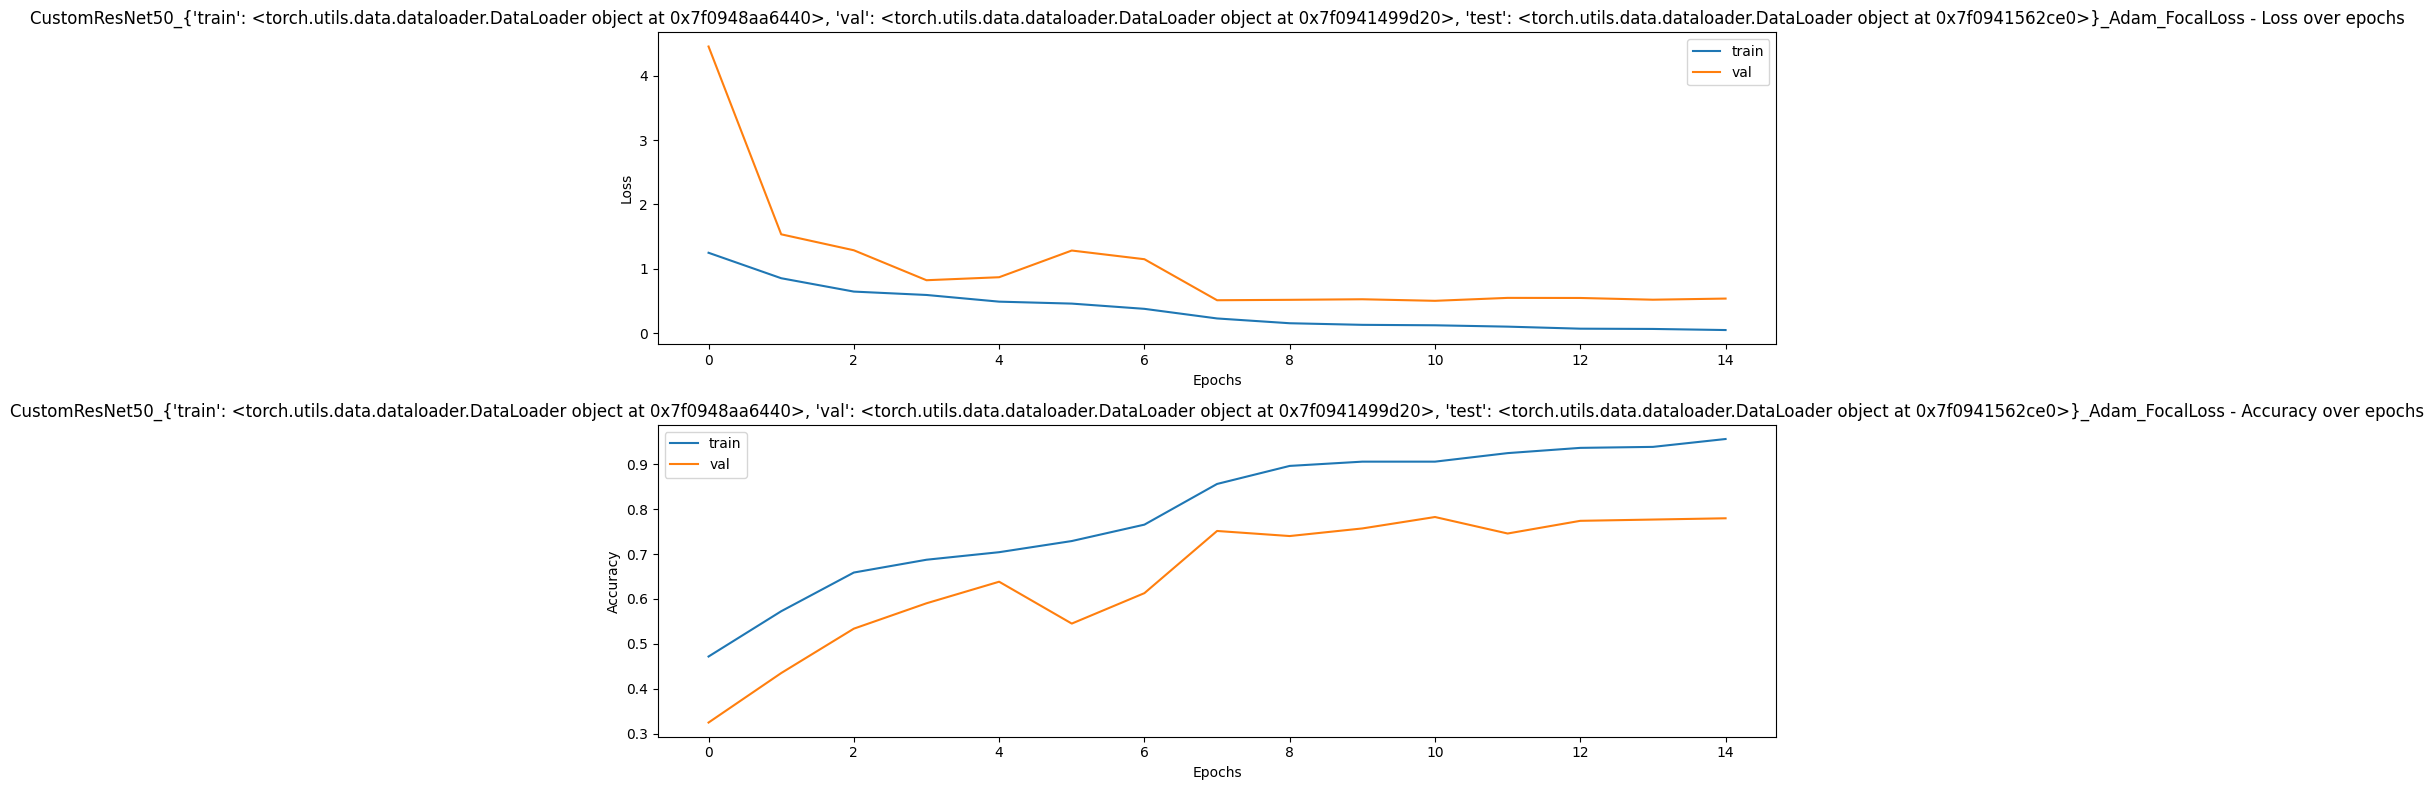


Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f094171db10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f094171e110>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f09417a27d0>}, SGD, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.9948 Acc: 0.3937
val Loss: 1.2795 Acc: 0.6045

Epoch 1/14
----------
train Loss: 0.9337 Acc: 0.7443
val Loss: 0.8930 Acc: 0.7260

Epoch 2/14
----------
train Loss: 0.5522 Acc: 0.8415
val Loss: 0.6825 Acc: 0.7825

Epoch 3/14
----------
train Loss: 0.3345 Acc: 0.9182
val Loss: 0.5781 Acc: 0.8164

Epoch 4/14
----------
train Loss: 0.2385 Acc: 0.9372
val Loss: 0.5788 Acc: 0.8107

Epoch 5/14
----------
train Loss: 0.1629 Acc: 0.9671
val Loss: 0.5940 Acc: 0.8164

Epoch 6/14
----------
train Loss: 0.1055 Acc: 0.9825
val Loss: 0.5670 Acc: 0.8220

Epoch 7/14
----------
train Loss: 0.0862 Acc: 0.9927
val Loss: 0.5645 Acc: 0.8305

Epoch 8/14
----------
train Loss: 0.0685 Acc: 0.9905
val

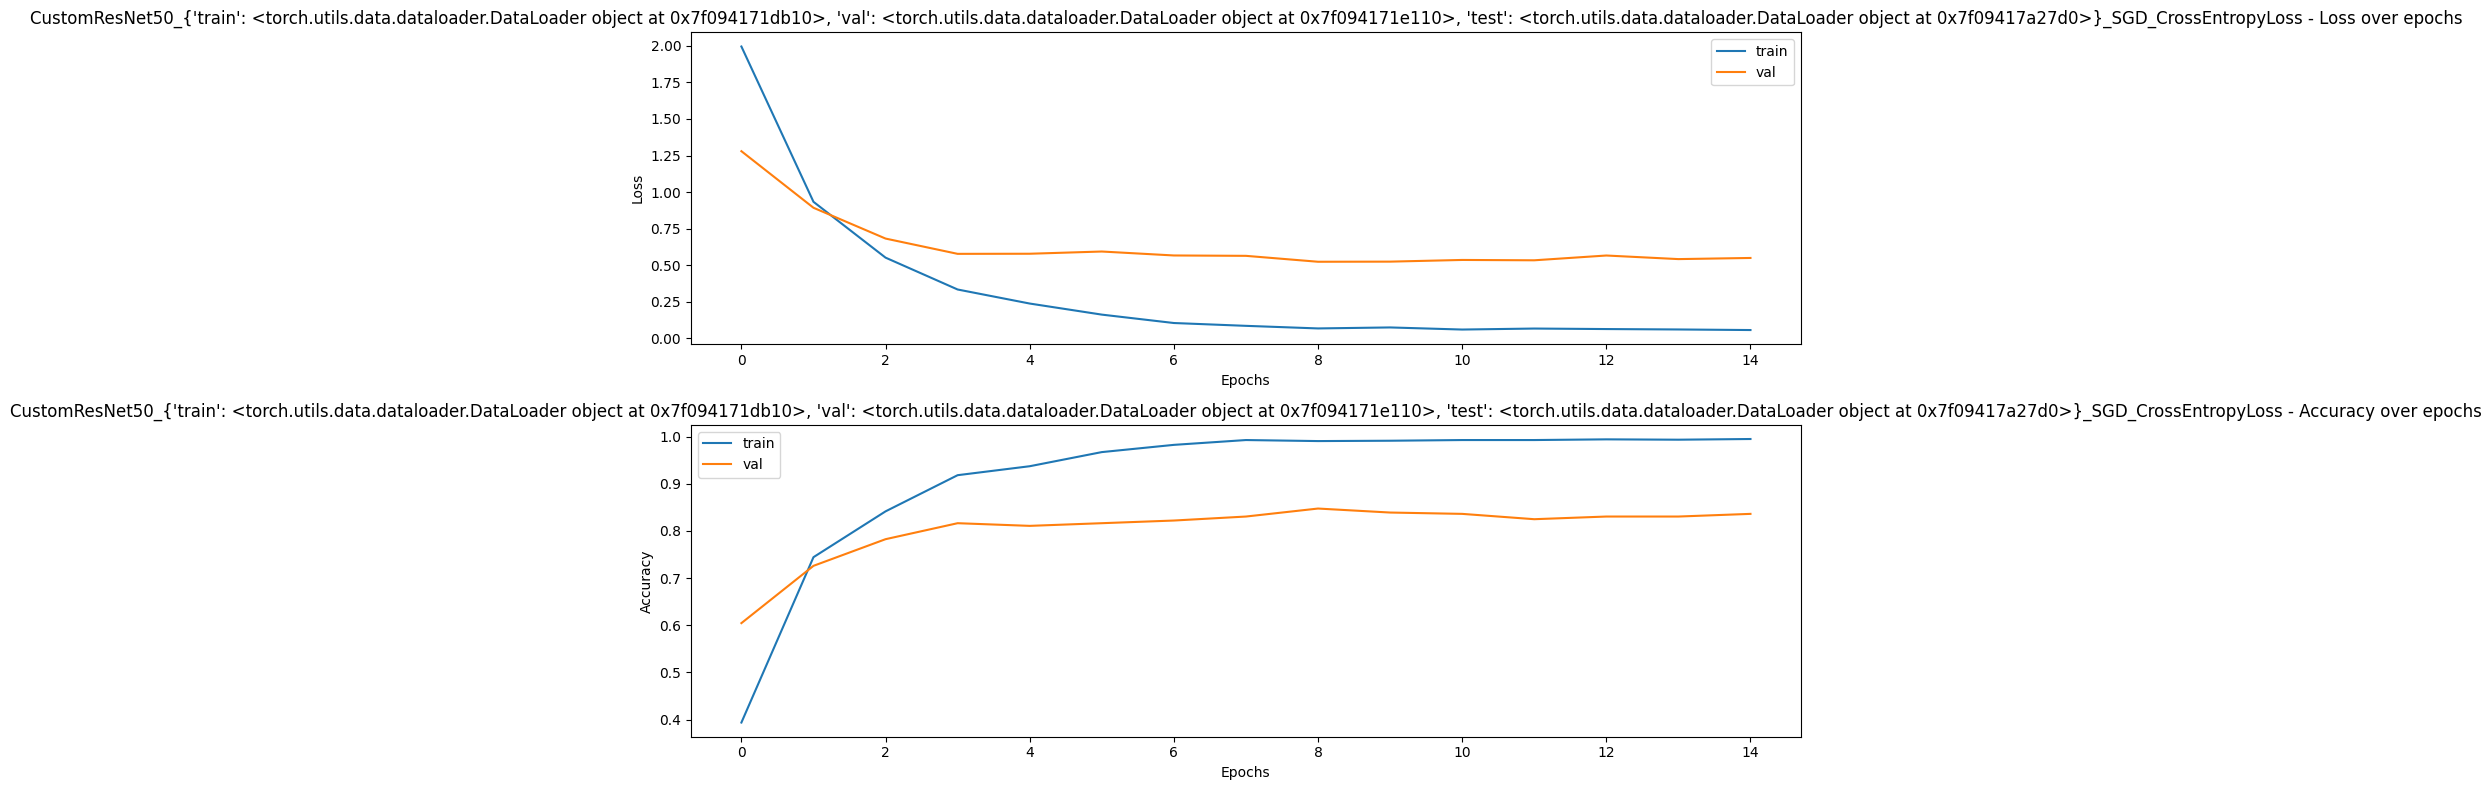


Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f094171db10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f094171e110>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f09417a27d0>}, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 1.4917 Acc: 0.4485
val Loss: 0.8009 Acc: 0.6554

Epoch 1/14
----------
train Loss: 0.4927 Acc: 0.7721
val Loss: 0.5535 Acc: 0.7514

Epoch 2/14
----------
train Loss: 0.2925 Acc: 0.8532
val Loss: 0.4321 Acc: 0.7768

Epoch 3/14
----------
train Loss: 0.1562 Acc: 0.9153
val Loss: 0.4250 Acc: 0.7797

Epoch 4/14
----------
train Loss: 0.0912 Acc: 0.9679
val Loss: 0.3882 Acc: 0.7825

Epoch 5/14
----------
train Loss: 0.0596 Acc: 0.9730
val Loss: 0.3809 Acc: 0.7994

Epoch 6/14
----------
train Loss: 0.0430 Acc: 0.9854
val Loss: 0.3964 Acc: 0.8136

Epoch 7/14
----------
train Loss: 0.0320 Acc: 0.9927
val Loss: 0.3898 Acc: 0.8136

Epoch 8/14
----------
train Loss: 0.0306 Acc: 0.9934
val Loss: 

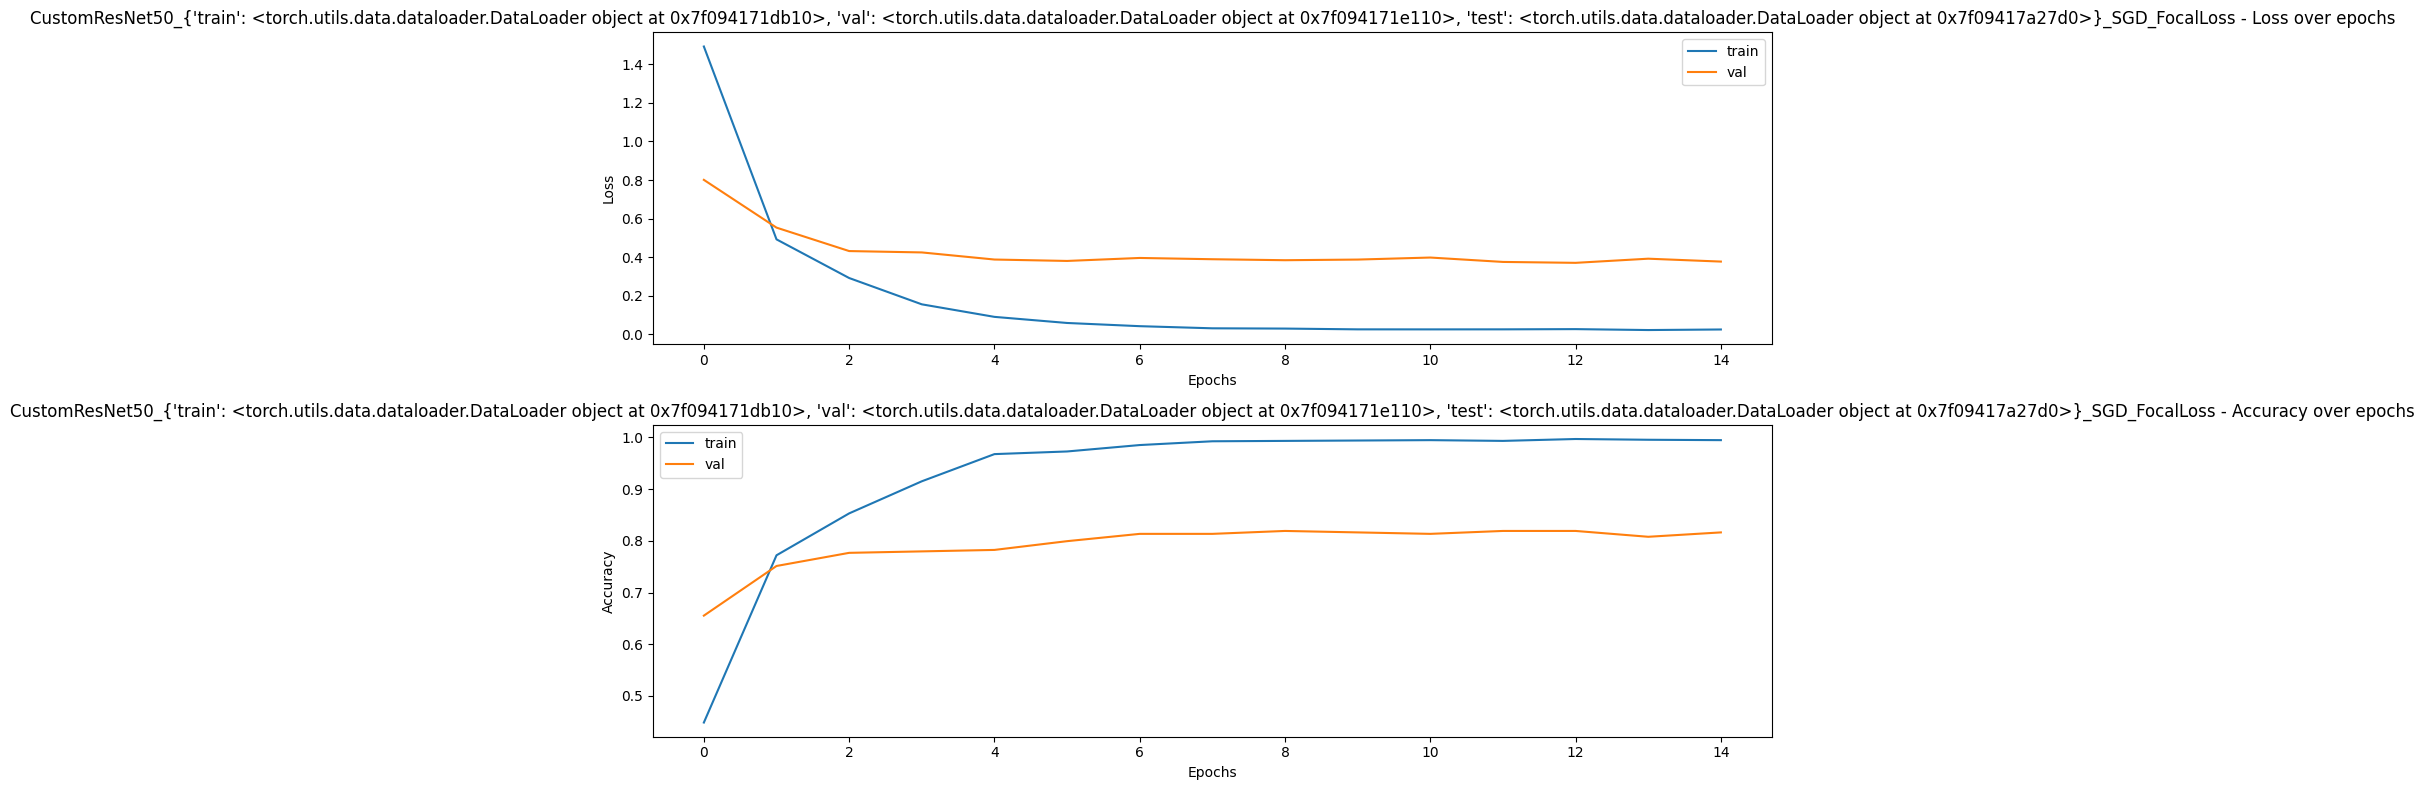


Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f094171db10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f094171e110>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f09417a27d0>}, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.7981 Acc: 0.4470
val Loss: 2.5498 Acc: 0.4294

Epoch 1/14
----------
train Loss: 1.2246 Acc: 0.5785
val Loss: 2.8633 Acc: 0.3249

Epoch 2/14
----------
train Loss: 1.0467 Acc: 0.6516
val Loss: 1.1418 Acc: 0.6582

Epoch 3/14
----------
train Loss: 0.9417 Acc: 0.6947
val Loss: 8.4158 Acc: 0.3333

Epoch 4/14
----------
train Loss: 0.7814 Acc: 0.7363
val Loss: 1.2657 Acc: 0.5904

Epoch 5/14
----------
train Loss: 0.6508 Acc: 0.7809
val Loss: 2.1525 Acc: 0.5085

Epoch 6/14
----------
train Loss: 0.5521 Acc: 0.8159
val Loss: 1.2865 Acc: 0.6356

Epoch 7/14
----------
train Loss: 0.3175 Acc: 0.8926
val Loss: 0.7160 Acc: 0.7768

Epoch 8/14
----------
train Loss: 0.2174 Acc: 0.9299
va

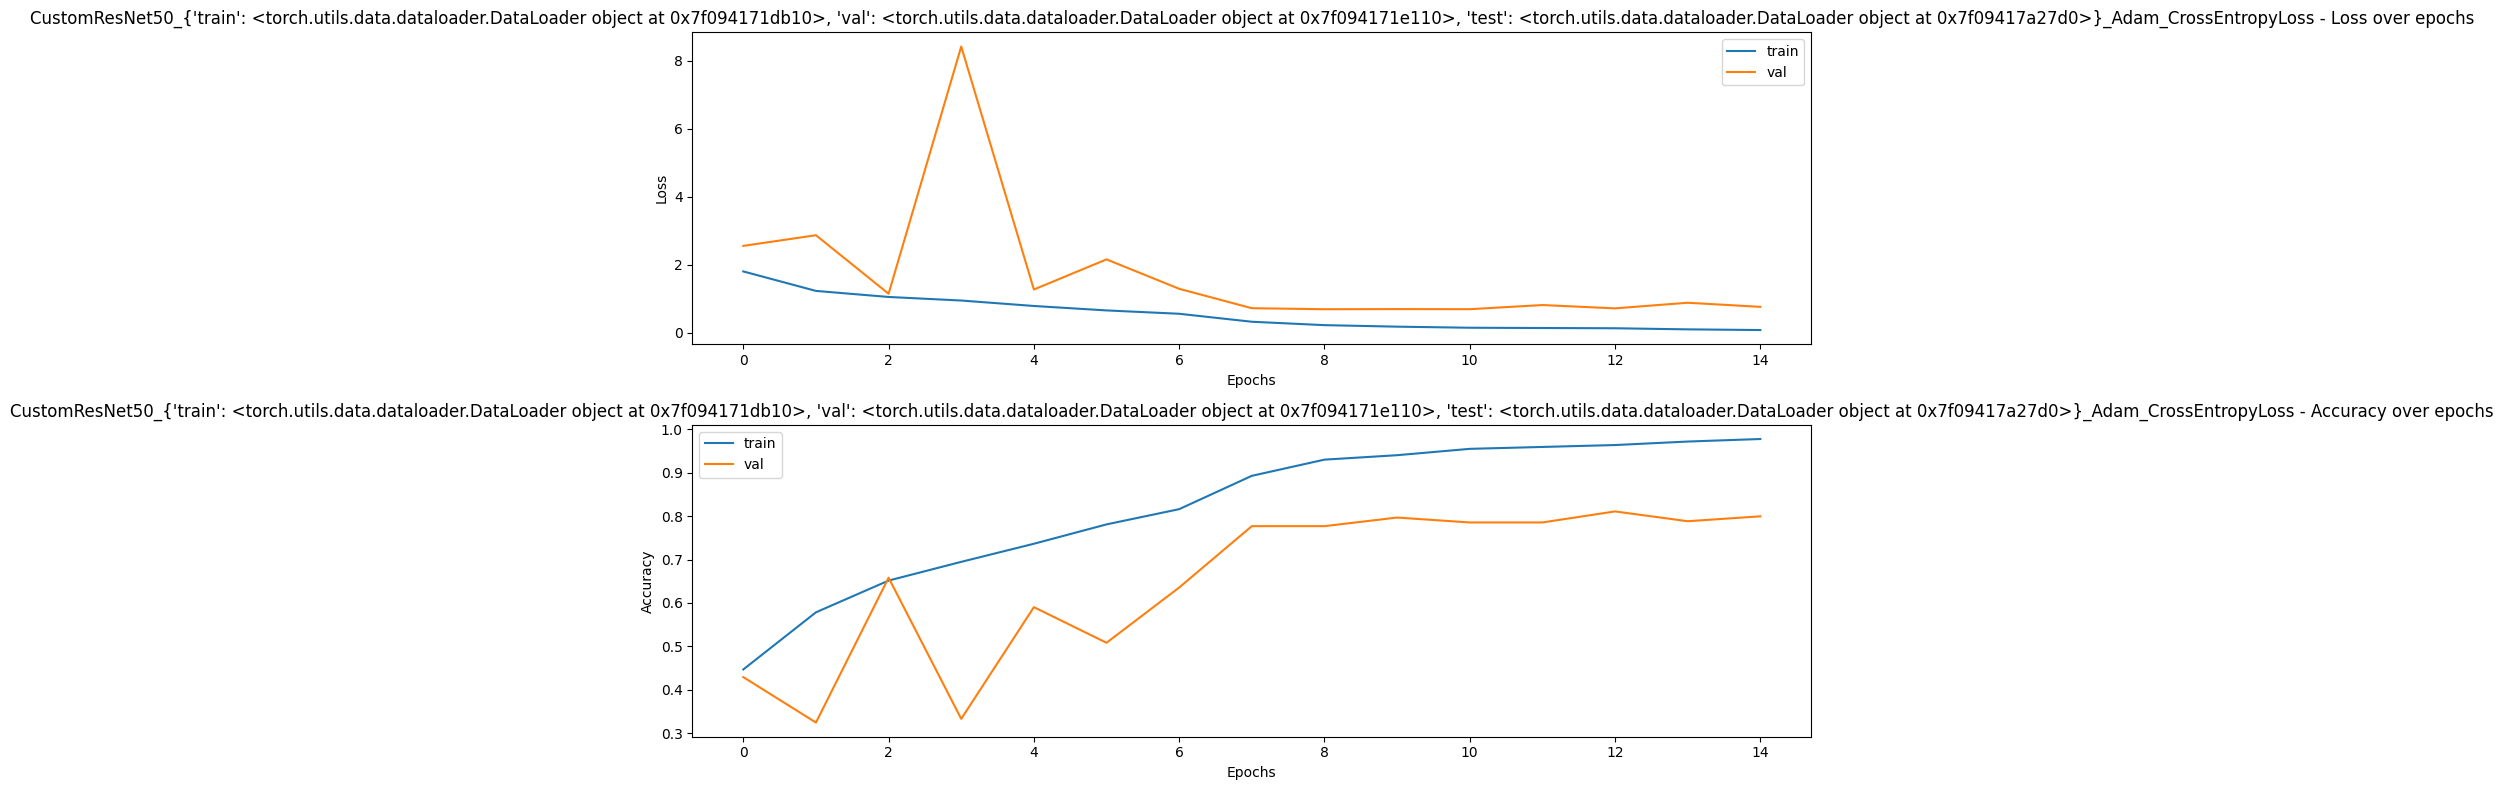


Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f094171db10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f094171e110>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f09417a27d0>}, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.3271 Acc: 0.4463
val Loss: 2.3080 Acc: 0.3164

Epoch 1/14
----------
train Loss: 0.8573 Acc: 0.5771
val Loss: 1.1509 Acc: 0.4774

Epoch 2/14
----------
train Loss: 0.6789 Acc: 0.6355
val Loss: 1.3801 Acc: 0.5000

Epoch 3/14
----------
train Loss: 0.5759 Acc: 0.6881
val Loss: 1.1653 Acc: 0.5565

Epoch 4/14
----------
train Loss: 0.4638 Acc: 0.7370
val Loss: 0.7759 Acc: 0.6667

Epoch 5/14
----------
train Loss: 0.4382 Acc: 0.7509
val Loss: 0.7769 Acc: 0.6949

Epoch 6/14
----------
train Loss: 0.3754 Acc: 0.7889
val Loss: 1.1560 Acc: 0.5706

Epoch 7/14
----------
train Loss: 0.2008 Acc: 0.8641
val Loss: 0.4913 Acc: 0.7486

Epoch 8/14
----------
train Loss: 0.1452 Acc: 0.9123
val Loss:

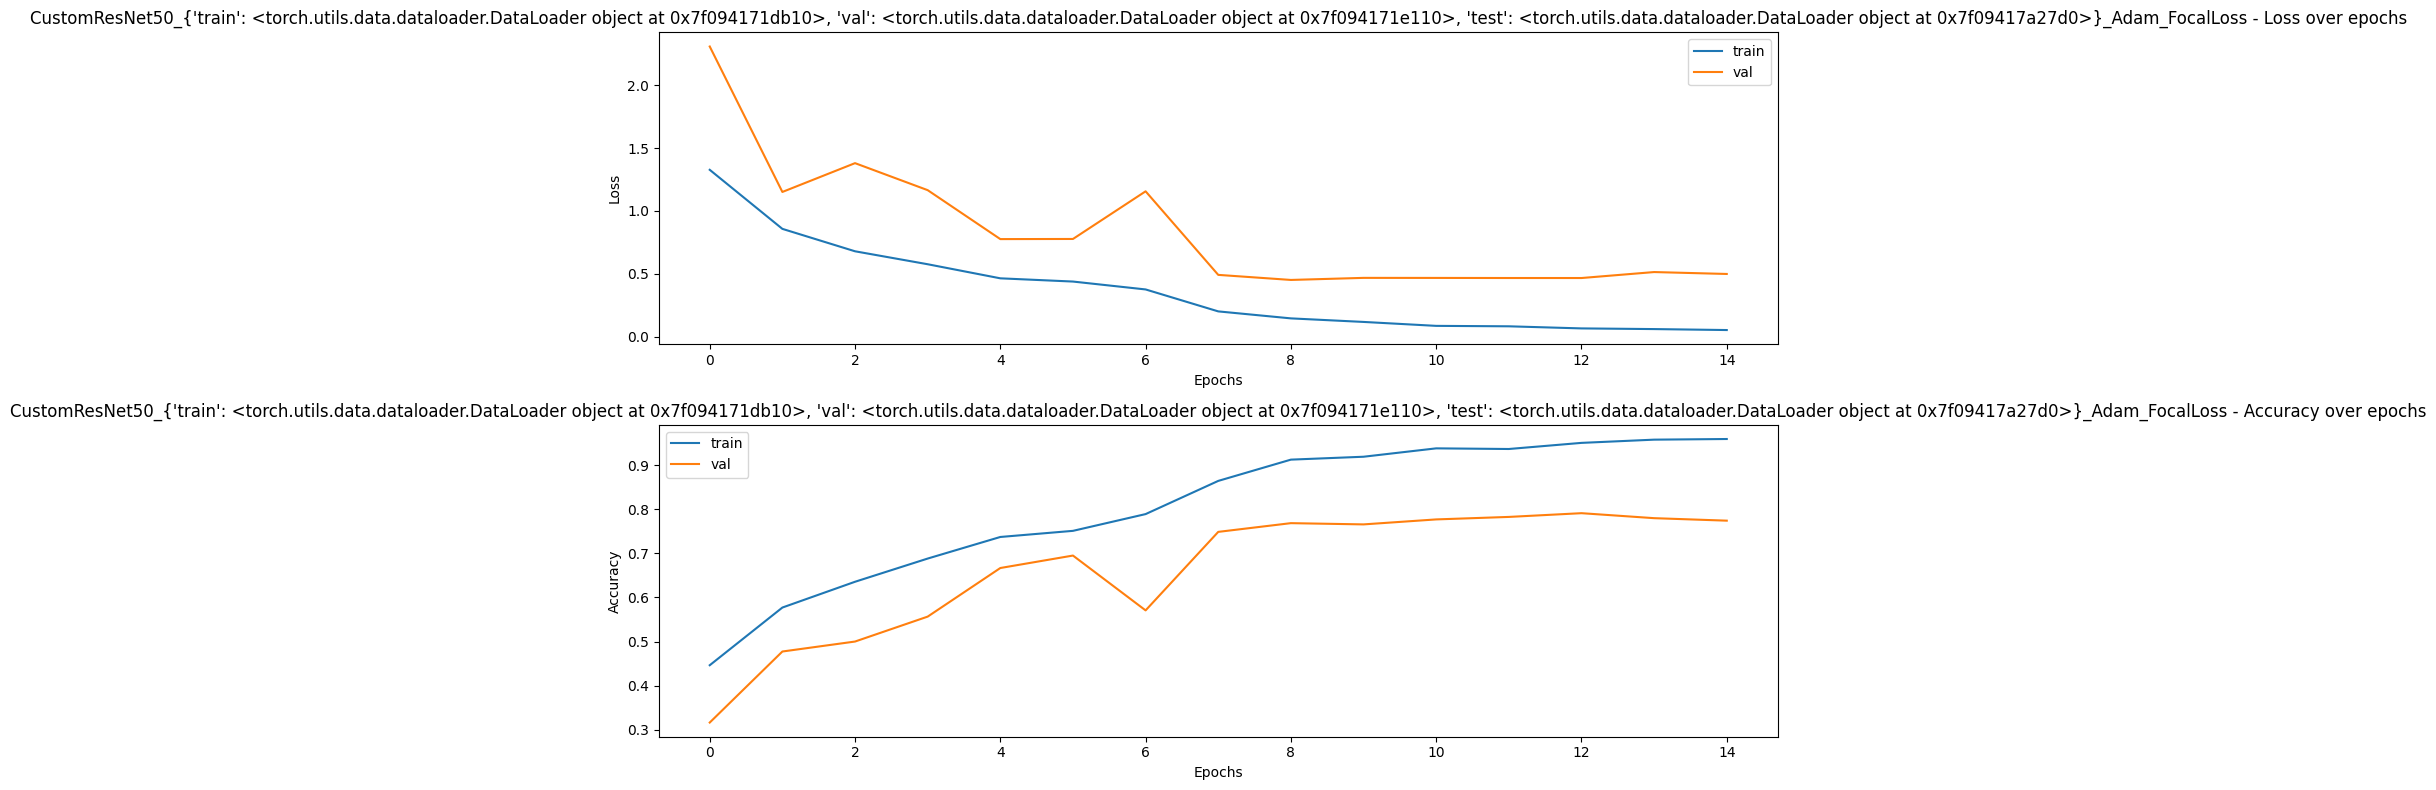


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f0948aa6440>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f0941499d20>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f0941562ce0>}, SGD, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 2.5381 Acc: 0.2257
val Loss: 2.1125 Acc: 0.3277

Epoch 1/14
----------
train Loss: 1.7199 Acc: 0.5099
val Loss: 1.3898 Acc: 0.6045

Epoch 2/14
----------
train Loss: 1.0952 Acc: 0.6866
val Loss: 0.9984 Acc: 0.6723

Epoch 3/14
----------
train Loss: 0.7355 Acc: 0.7984
val Loss: 0.8198 Acc: 0.7401

Epoch 4/14
----------
train Loss: 0.5386 Acc: 0.8510
val Loss: 0.7114 Acc: 0.7910

Epoch 5/14
----------
train Loss: 0.3942 Acc: 0.8831
val Loss: 0.5998 Acc: 0.8164

Epoch 6/14
----------
train Loss: 0.2830 Acc: 0.9226
val Loss: 0.7210 Acc: 0.7684

Epoch 7/14
----------
train Loss: 0.2320 Acc: 0.9372
val Loss: 0.5813 Acc: 0.8249

Epoch 8/14
----------
train Loss: 0.2051 Acc: 0.9503
va

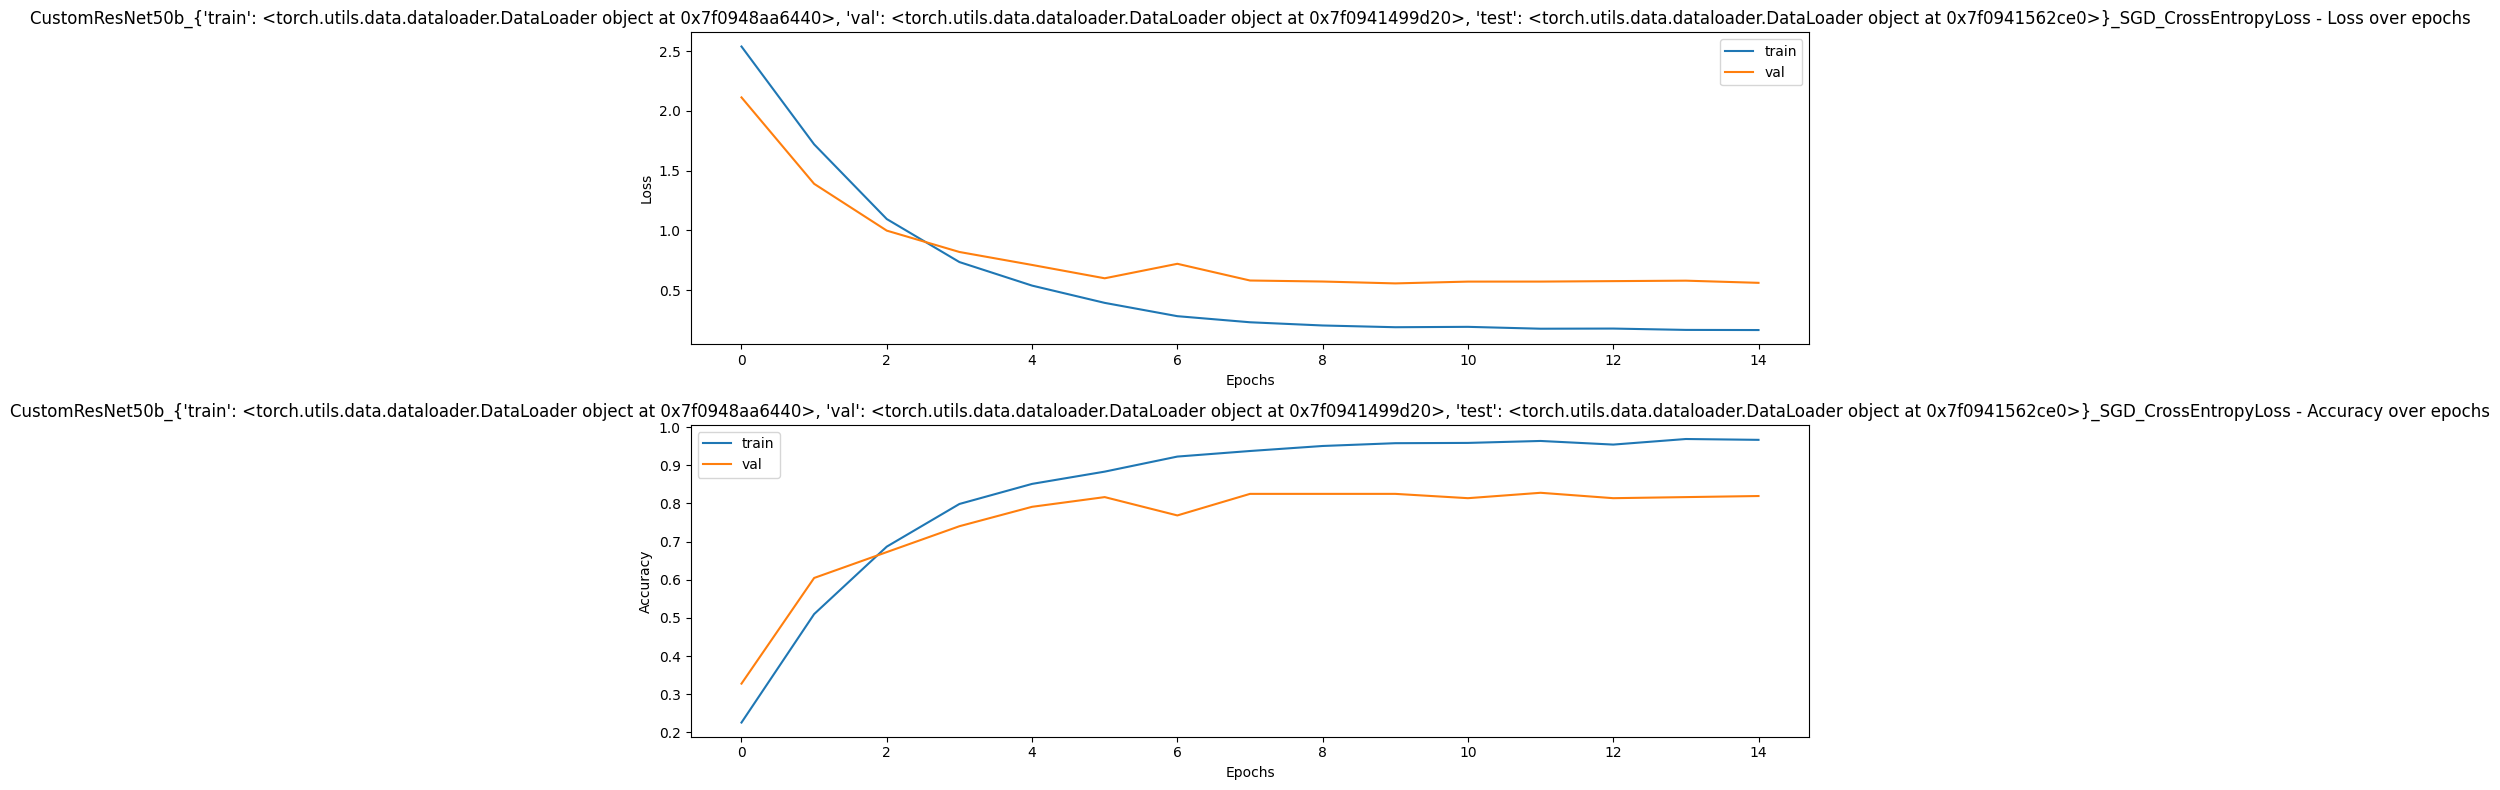


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f0948aa6440>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f0941499d20>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f0941562ce0>}, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 2.0858 Acc: 0.2586
val Loss: 1.5255 Acc: 0.4266

Epoch 1/14
----------
train Loss: 1.1445 Acc: 0.5632
val Loss: 0.8759 Acc: 0.6441

Epoch 2/14
----------
train Loss: 0.6132 Acc: 0.7319
val Loss: 0.5640 Acc: 0.7345

Epoch 3/14
----------
train Loss: 0.3936 Acc: 0.8020
val Loss: 0.4870 Acc: 0.7514

Epoch 4/14
----------
train Loss: 0.2575 Acc: 0.8546
val Loss: 0.4608 Acc: 0.7655

Epoch 5/14
----------
train Loss: 0.1759 Acc: 0.9065
val Loss: 0.4315 Acc: 0.7853

Epoch 6/14
----------
train Loss: 0.1292 Acc: 0.9321
val Loss: 0.3711 Acc: 0.7938

Epoch 7/14
----------
train Loss: 0.0871 Acc: 0.9591
val Loss: 0.3812 Acc: 0.8051

Epoch 8/14
----------
train Loss: 0.0879 Acc: 0.9642
val Loss:

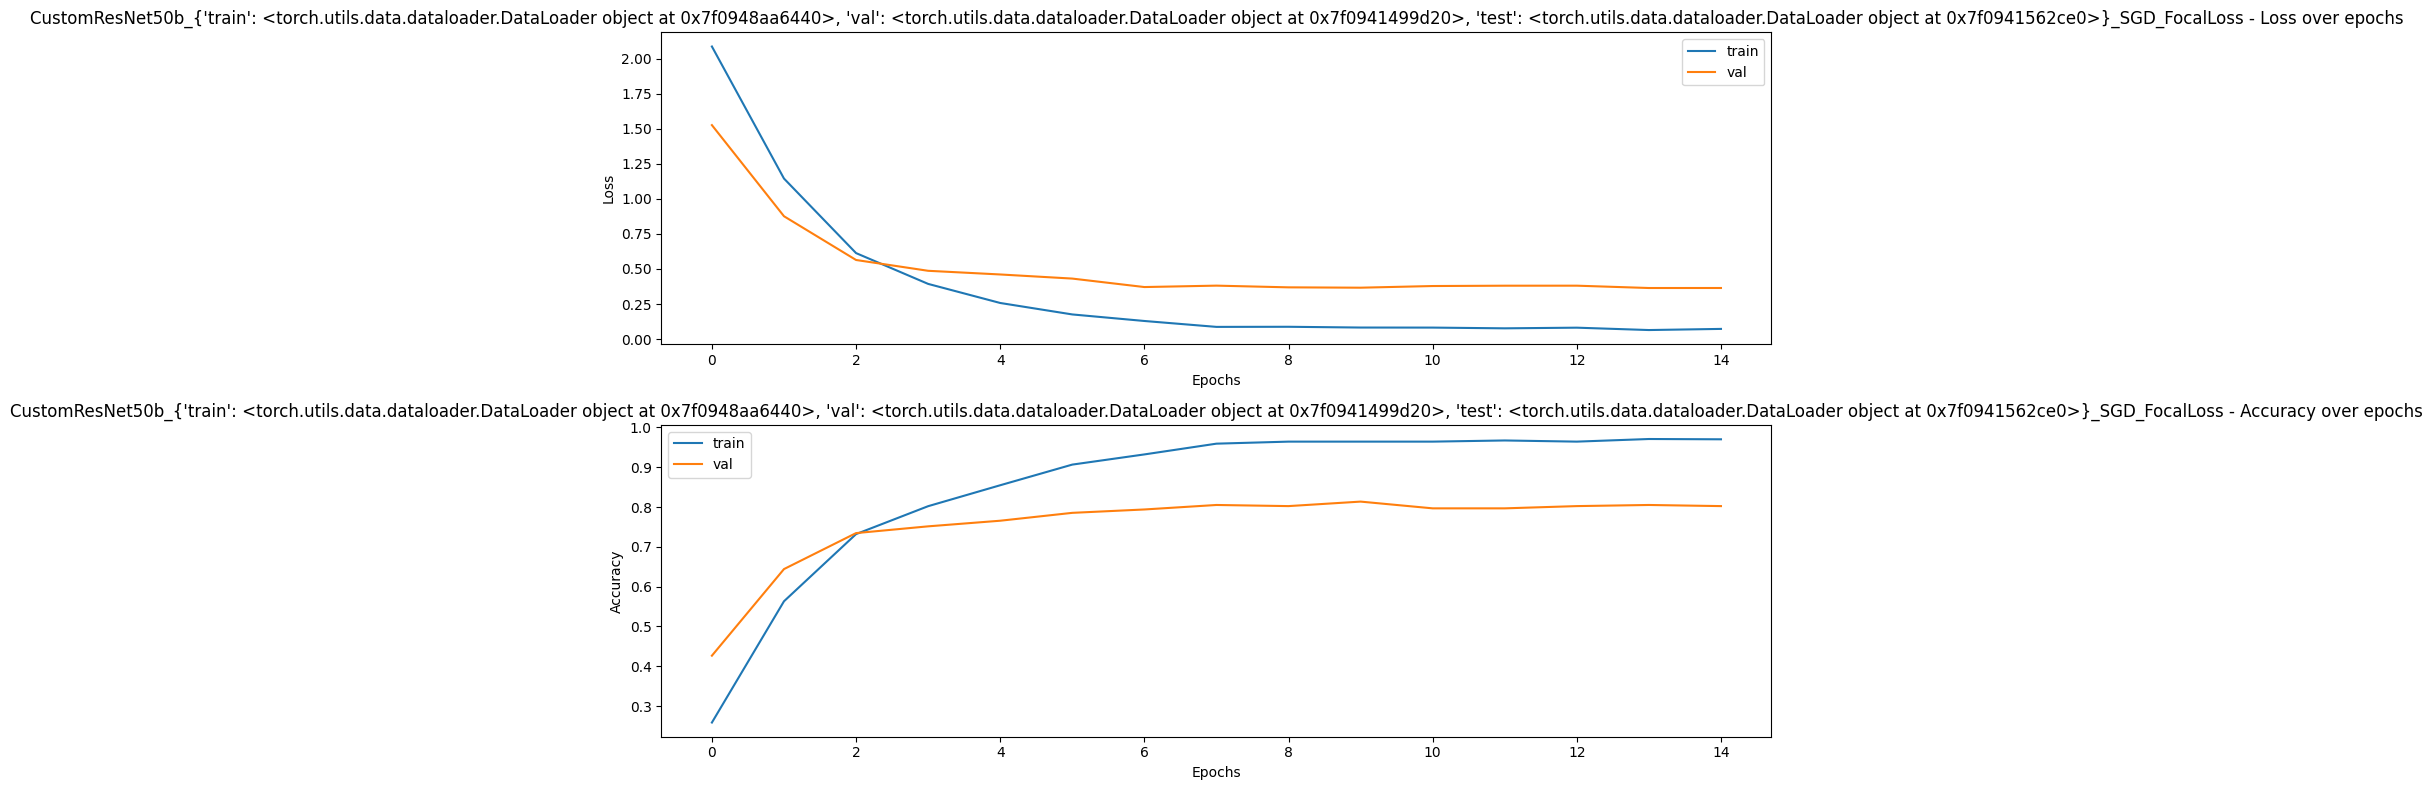


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f0948aa6440>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f0941499d20>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f0941562ce0>}, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 2.0060 Acc: 0.3192
val Loss: 2.5648 Acc: 0.3390

Epoch 1/14
----------
train Loss: 1.4489 Acc: 0.4836
val Loss: 1.8490 Acc: 0.3729

Epoch 2/14
----------
train Loss: 1.3144 Acc: 0.5281
val Loss: 1.3872 Acc: 0.5000

Epoch 3/14
----------
train Loss: 1.2411 Acc: 0.5771
val Loss: 1.4394 Acc: 0.4972

Epoch 4/14
----------
train Loss: 1.0925 Acc: 0.5968
val Loss: 2.4792 Acc: 0.3672

Epoch 5/14
----------
train Loss: 1.0685 Acc: 0.6129
val Loss: 1.3927 Acc: 0.5706

Epoch 6/14
----------
train Loss: 0.9462 Acc: 0.6538
val Loss: 1.2368 Acc: 0.5311

Epoch 7/14
----------
train Loss: 0.7218 Acc: 0.7356
val Loss: 0.9185 Acc: 0.6723

Epoch 8/14
----------
train Loss: 0.6302 Acc: 0.7648
v

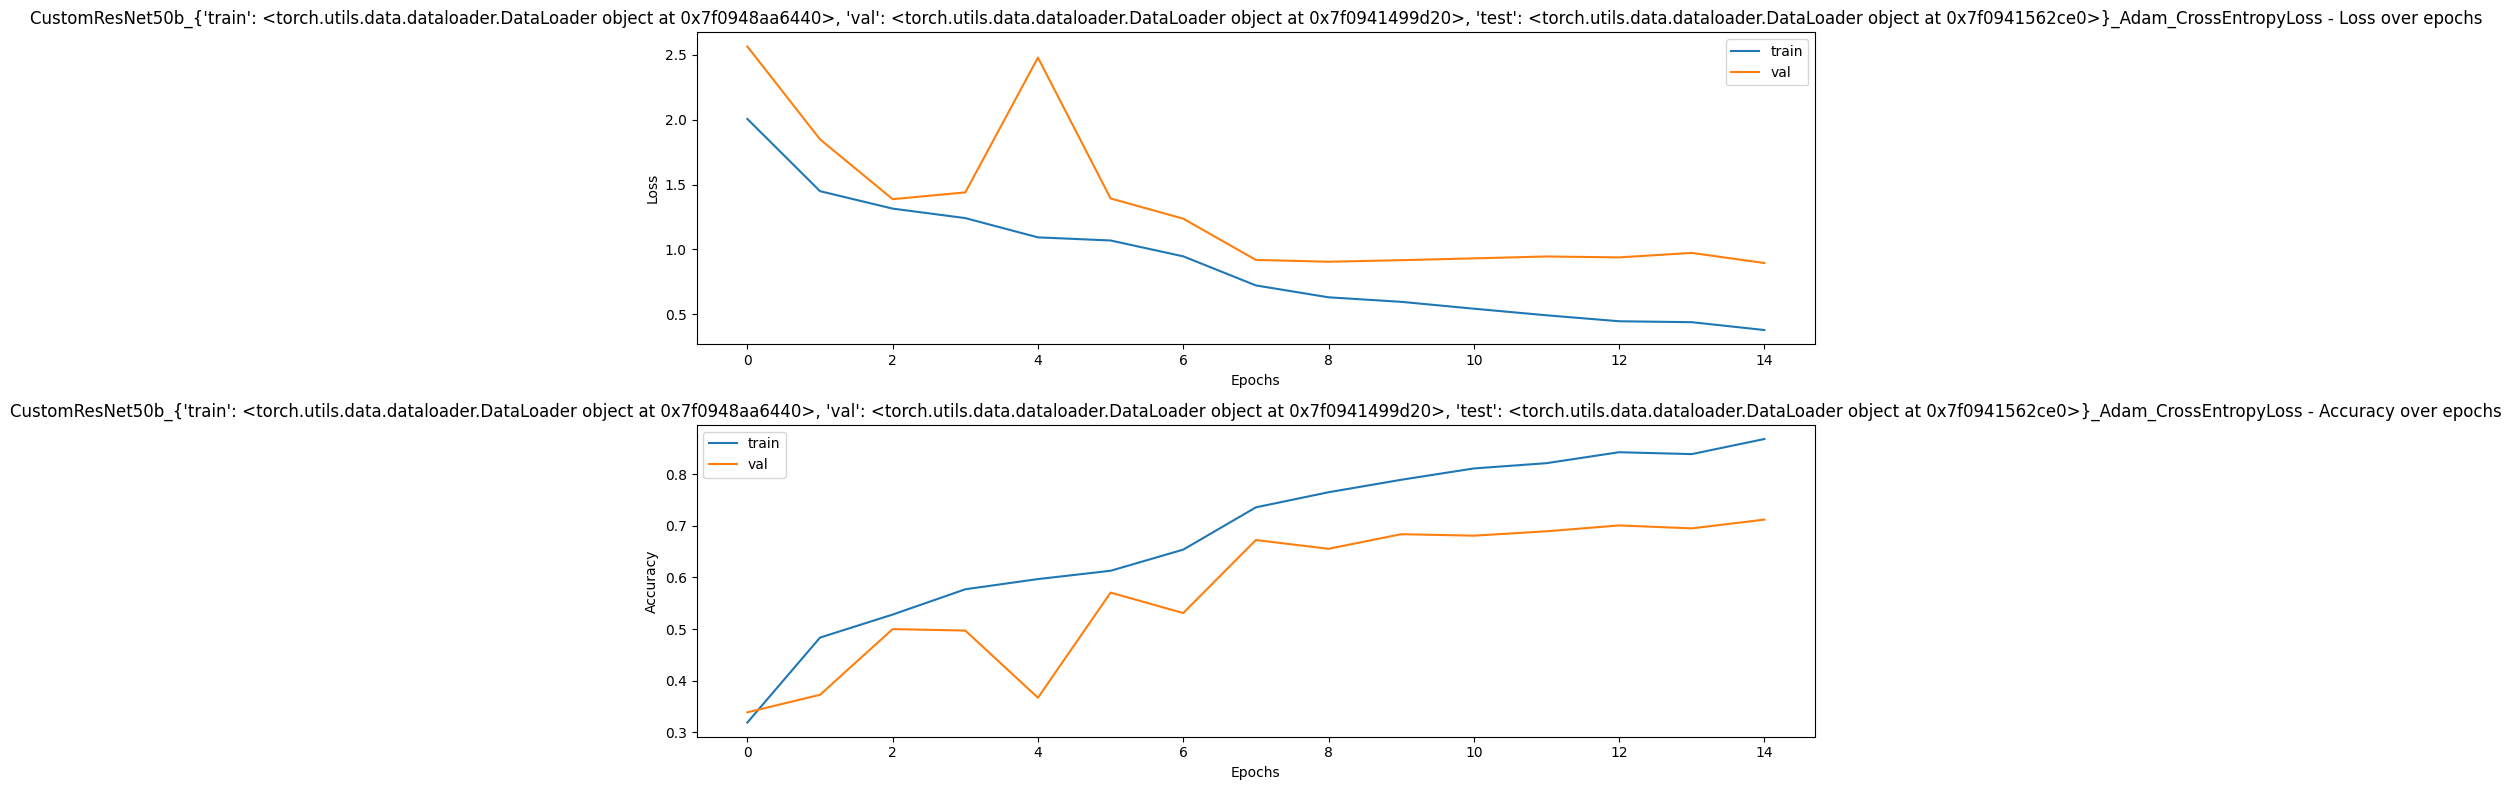


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f0948aa6440>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f0941499d20>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f0941562ce0>}, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.5489 Acc: 0.3411
val Loss: 2.4231 Acc: 0.2910

Epoch 1/14
----------
train Loss: 1.1012 Acc: 0.4288
val Loss: 1.3724 Acc: 0.3531

Epoch 2/14
----------
train Loss: 0.9010 Acc: 0.5296
val Loss: 3.1027 Acc: 0.2684

Epoch 3/14
----------
train Loss: 0.7695 Acc: 0.5551
val Loss: 1.0712 Acc: 0.4407

Epoch 4/14
----------
train Loss: 0.6569 Acc: 0.6048
val Loss: 0.7592 Acc: 0.5932

Epoch 5/14
----------
train Loss: 0.5642 Acc: 0.6150
val Loss: 1.1757 Acc: 0.4548

Epoch 6/14
----------
train Loss: 0.4957 Acc: 0.6676
val Loss: 1.0245 Acc: 0.5932

Epoch 7/14
----------
train Loss: 0.3443 Acc: 0.7509
val Loss: 0.5679 Acc: 0.6808

Epoch 8/14
----------
train Loss: 0.3027 Acc: 0.7677
val Loss

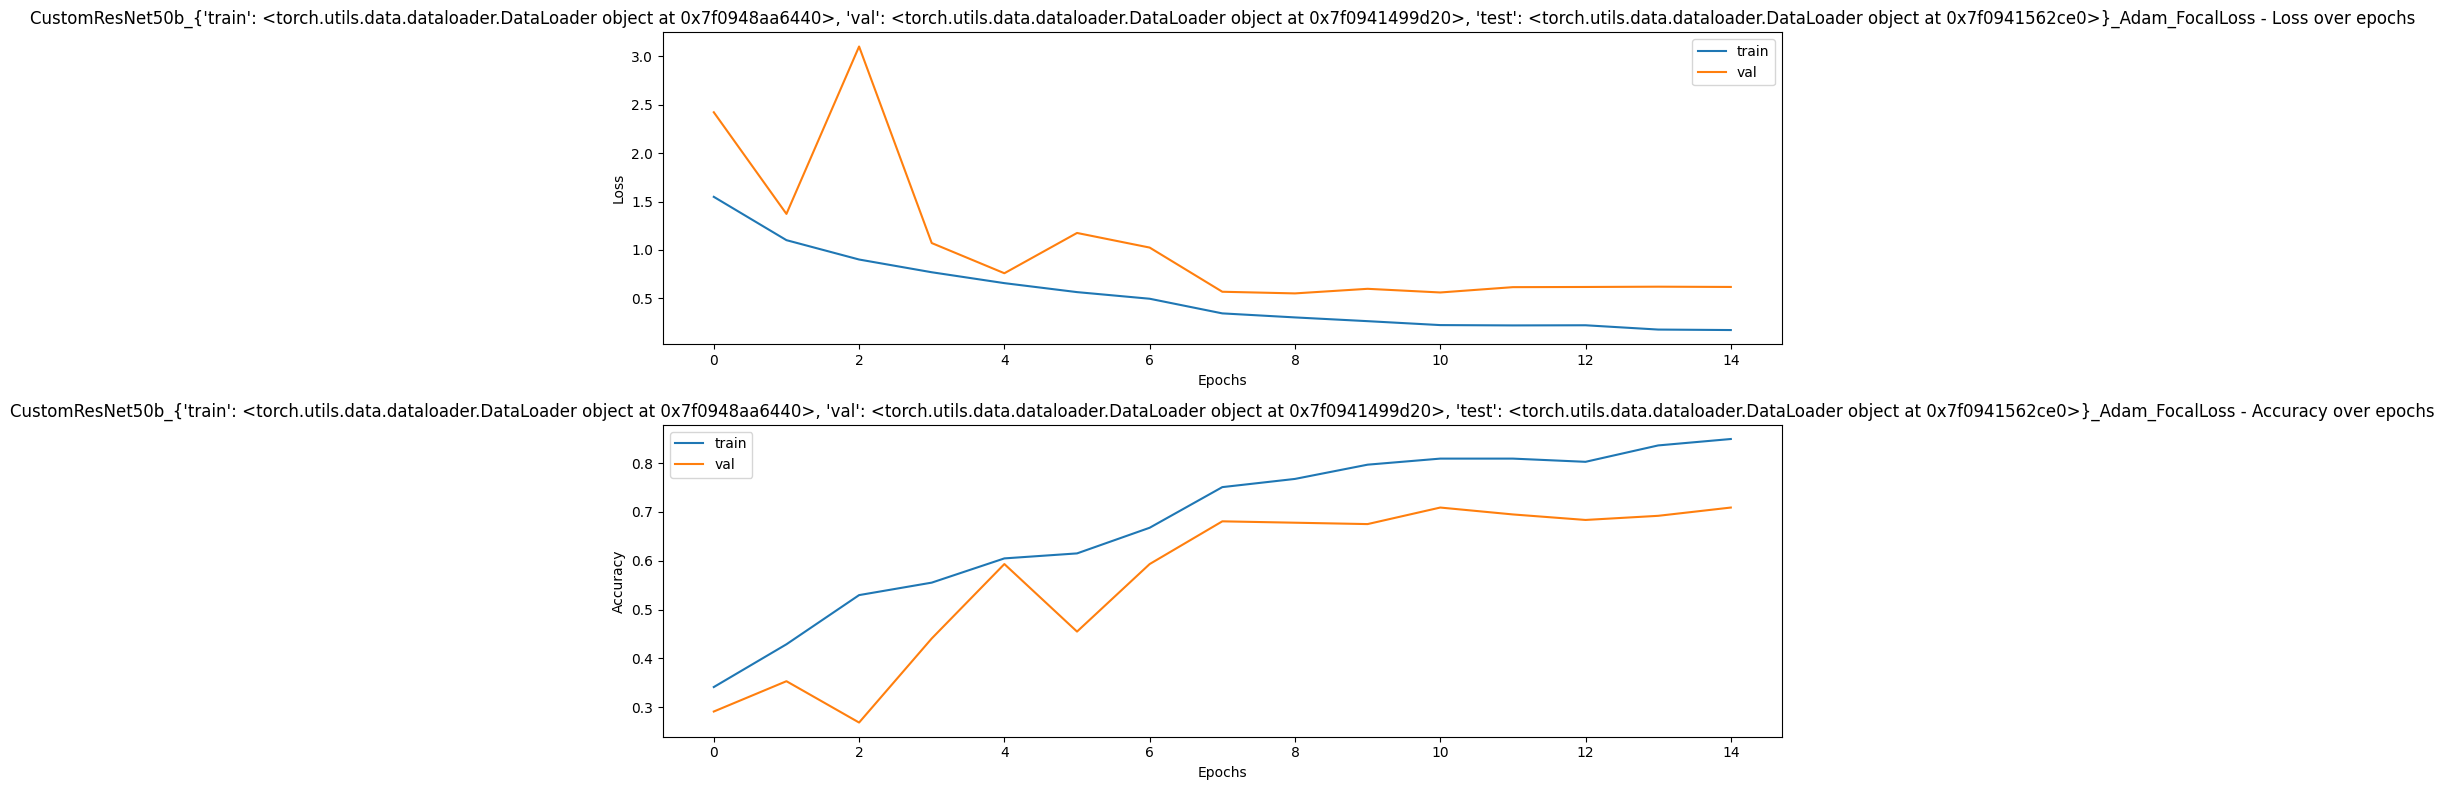


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f094171db10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f094171e110>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f09417a27d0>}, SGD, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 2.5167 Acc: 0.2294
val Loss: 2.1136 Acc: 0.3983

Epoch 1/14
----------
train Loss: 1.7506 Acc: 0.5011
val Loss: 1.4180 Acc: 0.5678

Epoch 2/14
----------
train Loss: 1.1116 Acc: 0.6917
val Loss: 1.1382 Acc: 0.6808

Epoch 3/14
----------
train Loss: 0.7673 Acc: 0.7816
val Loss: 0.8556 Acc: 0.7542

Epoch 4/14
----------
train Loss: 0.5367 Acc: 0.8466
val Loss: 0.6944 Acc: 0.8023

Epoch 5/14
----------
train Loss: 0.3814 Acc: 0.8963
val Loss: 0.7234 Acc: 0.7740

Epoch 6/14
----------
train Loss: 0.2730 Acc: 0.9270
val Loss: 0.6723 Acc: 0.8051

Epoch 7/14
----------
train Loss: 0.2272 Acc: 0.9525
val Loss: 0.6343 Acc: 0.8220

Epoch 8/14
----------
train Loss: 0.1946 Acc: 0.9584
va

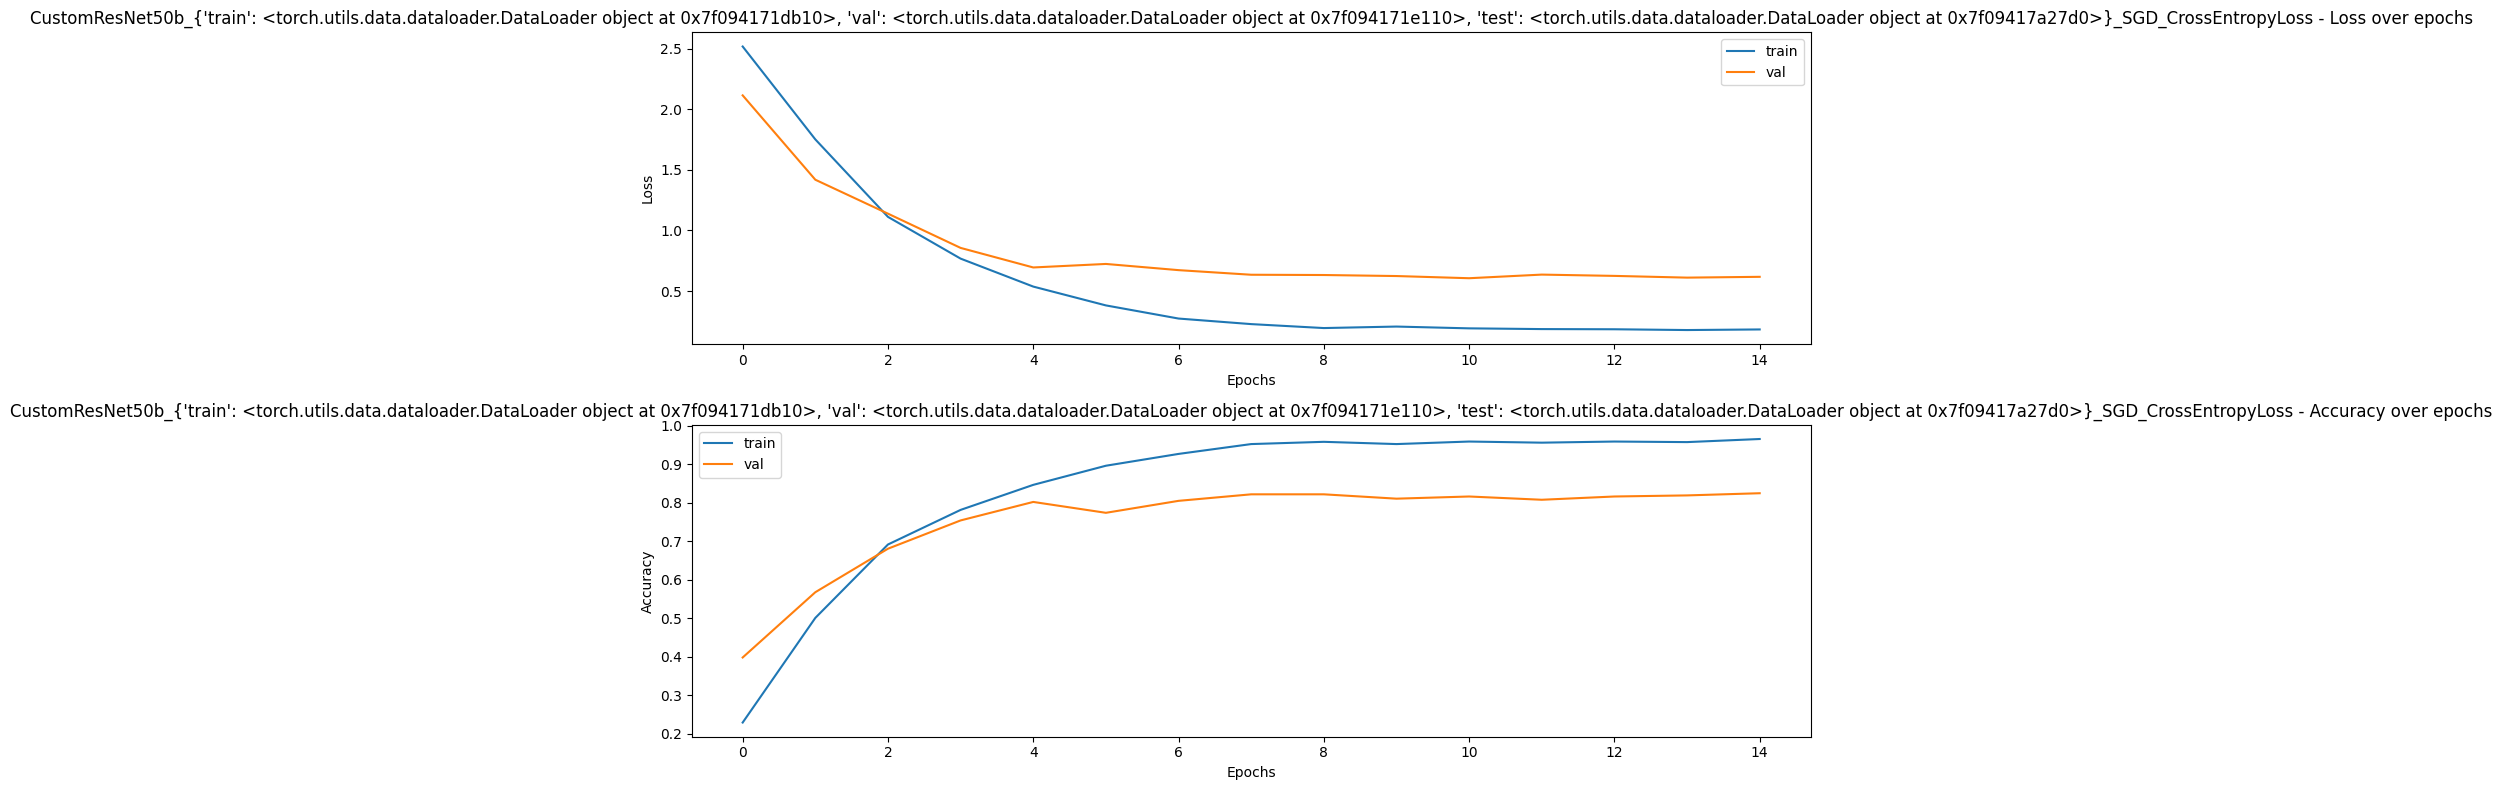


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f094171db10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f094171e110>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f09417a27d0>}, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 2.0960 Acc: 0.2264
val Loss: 1.5755 Acc: 0.3955

Epoch 1/14
----------
train Loss: 1.1477 Acc: 0.5588
val Loss: 0.9189 Acc: 0.6130

Epoch 2/14
----------
train Loss: 0.6323 Acc: 0.7195
val Loss: 0.6250 Acc: 0.7147

Epoch 3/14
----------
train Loss: 0.3857 Acc: 0.8196
val Loss: 0.5742 Acc: 0.7090

Epoch 4/14
----------
train Loss: 0.2689 Acc: 0.8568
val Loss: 0.4827 Acc: 0.7740

Epoch 5/14
----------
train Loss: 0.1862 Acc: 0.8977
val Loss: 0.4493 Acc: 0.7458

Epoch 6/14
----------
train Loss: 0.1524 Acc: 0.9058
val Loss: 0.4500 Acc: 0.7542

Epoch 7/14
----------
train Loss: 0.1090 Acc: 0.9459
val Loss: 0.4207 Acc: 0.7797

Epoch 8/14
----------
train Loss: 0.0894 Acc: 0.9569
val Loss:

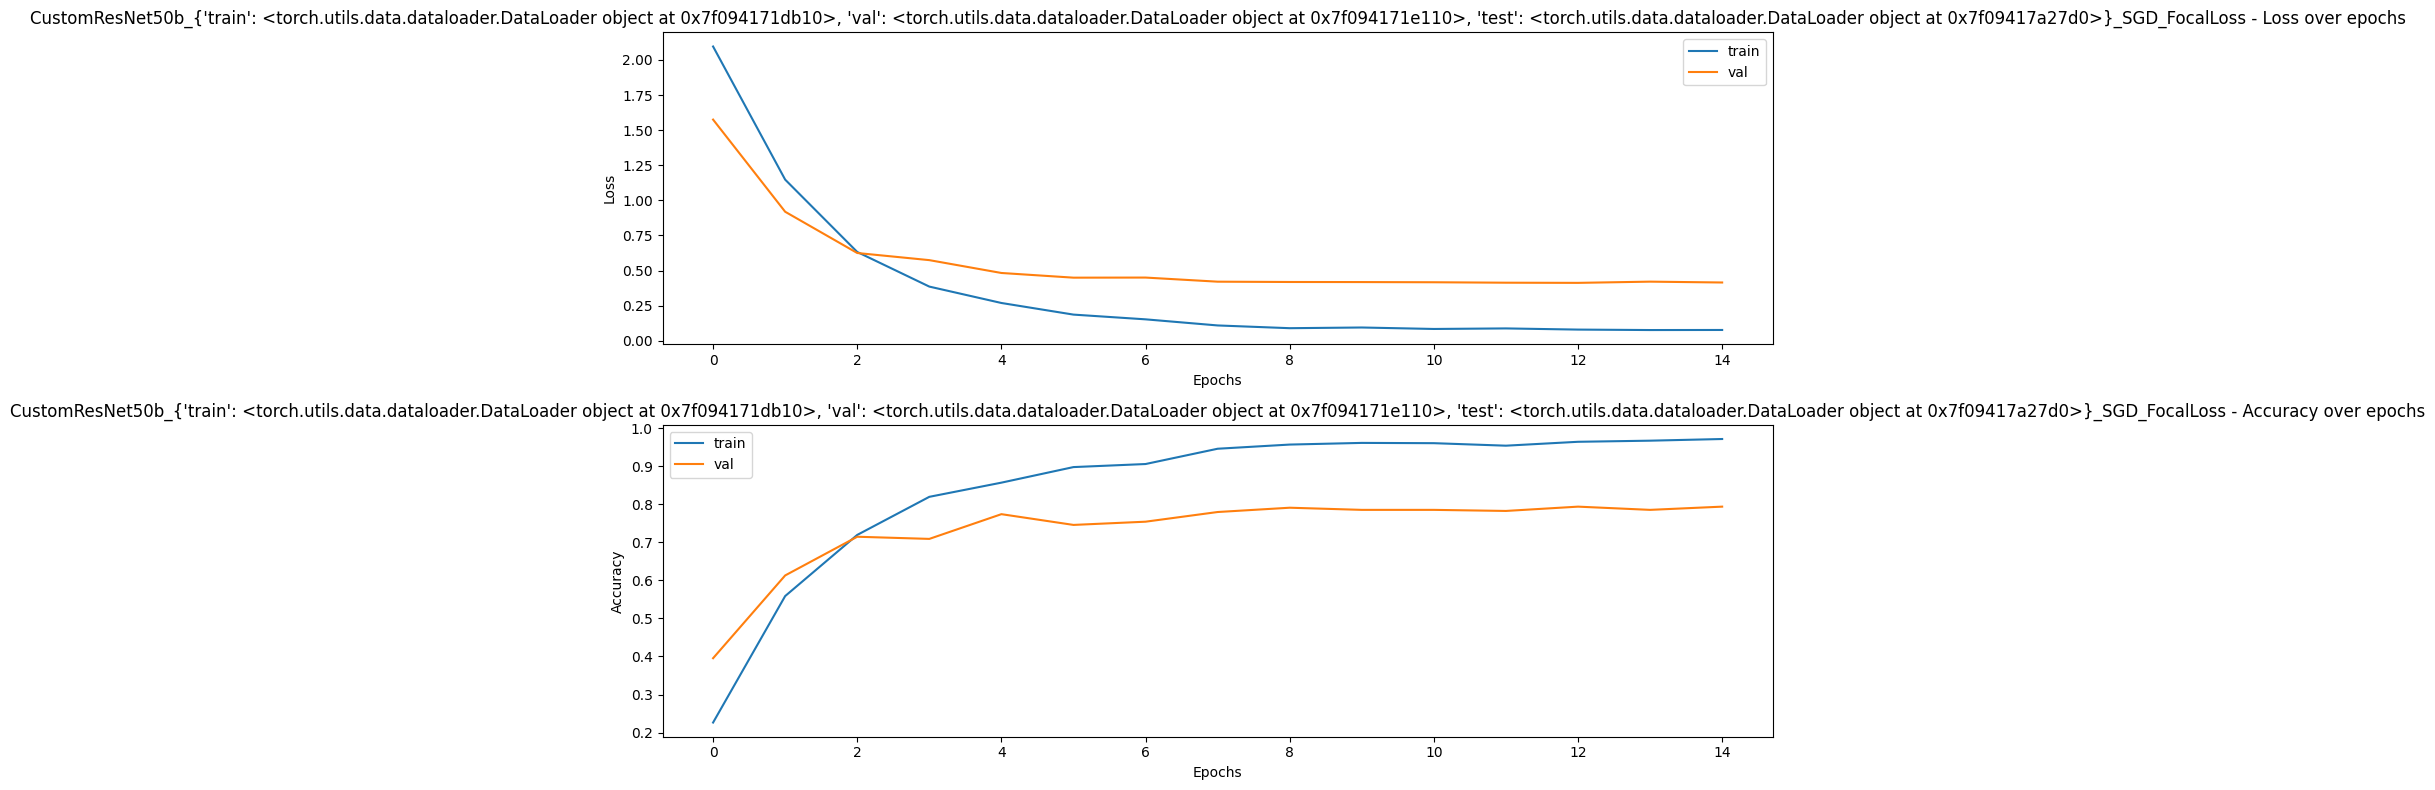


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f094171db10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f094171e110>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f09417a27d0>}, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.9565 Acc: 0.3506
val Loss: 2.2811 Acc: 0.3164

Epoch 1/14
----------
train Loss: 1.3949 Acc: 0.4996
val Loss: 2.3625 Acc: 0.3531

Epoch 2/14
----------
train Loss: 1.2320 Acc: 0.5720
val Loss: 1.5593 Acc: 0.5226

Epoch 3/14
----------
train Loss: 1.1318 Acc: 0.5982
val Loss: 1.2811 Acc: 0.5480

Epoch 4/14
----------
train Loss: 1.0290 Acc: 0.6260
val Loss: 1.3495 Acc: 0.5254

Epoch 5/14
----------
train Loss: 0.9649 Acc: 0.6574
val Loss: 2.3986 Acc: 0.3983

Epoch 6/14
----------
train Loss: 0.8541 Acc: 0.7129
val Loss: 1.9004 Acc: 0.4520

Epoch 7/14
----------
train Loss: 0.6862 Acc: 0.7509
val Loss: 1.0992 Acc: 0.6469

Epoch 8/14
----------
train Loss: 0.5792 Acc: 0.7757
v

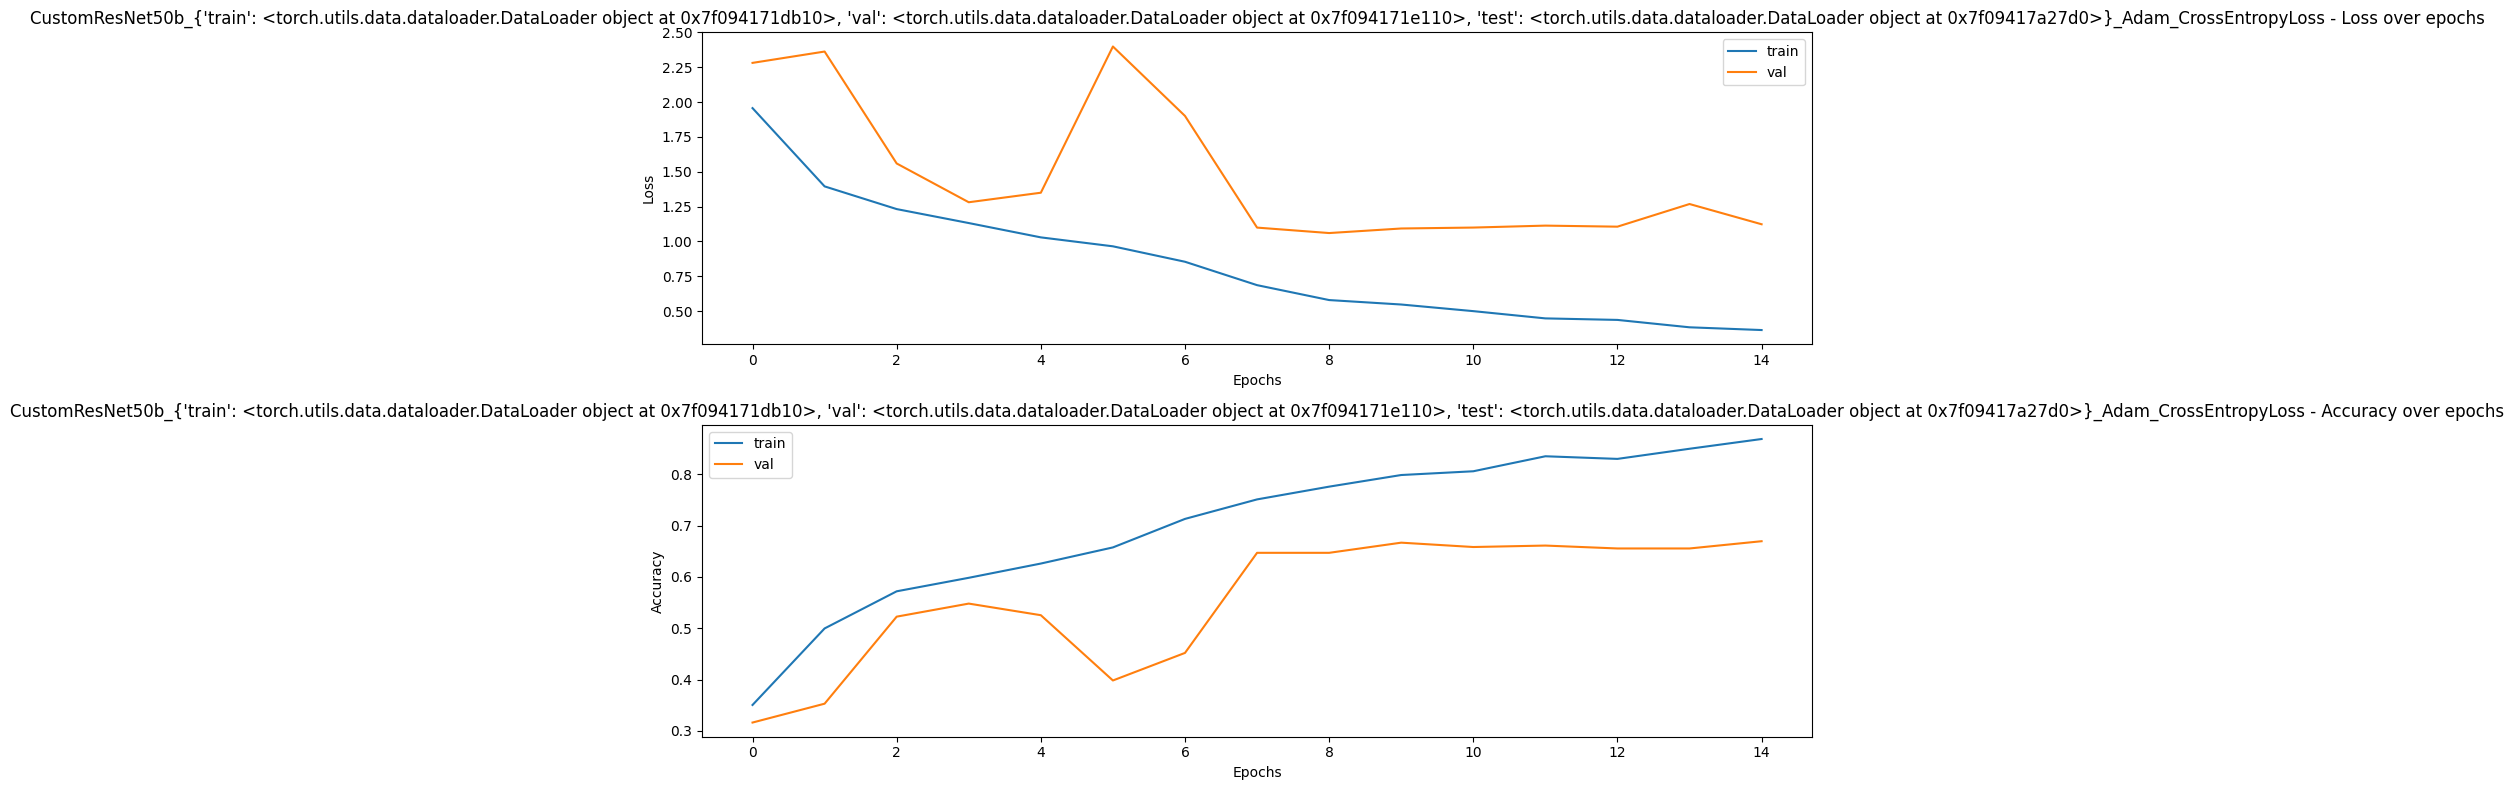


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f094171db10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f094171e110>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f09417a27d0>}, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.5335 Acc: 0.3506
val Loss: 2.1897 Acc: 0.2994

Epoch 1/14
----------
train Loss: 1.1096 Acc: 0.4434
val Loss: 1.3439 Acc: 0.4350

Epoch 2/14
----------
train Loss: 0.8345 Acc: 0.5347
val Loss: 2.1272 Acc: 0.3446

Epoch 3/14
----------
train Loss: 0.7584 Acc: 0.5595
val Loss: 0.9491 Acc: 0.5282

Epoch 4/14
----------
train Loss: 0.6696 Acc: 0.5895
val Loss: 1.1299 Acc: 0.4661

Epoch 5/14
----------
train Loss: 0.6503 Acc: 0.6019
val Loss: 0.9122 Acc: 0.5706

Epoch 6/14
----------
train Loss: 0.5617 Acc: 0.6662
val Loss: 0.8991 Acc: 0.5508

Epoch 7/14
----------
train Loss: 0.3794 Acc: 0.7458
val Loss: 0.7025 Acc: 0.6554

Epoch 8/14
----------
train Loss: 0.3504 Acc: 0.7451
val Loss

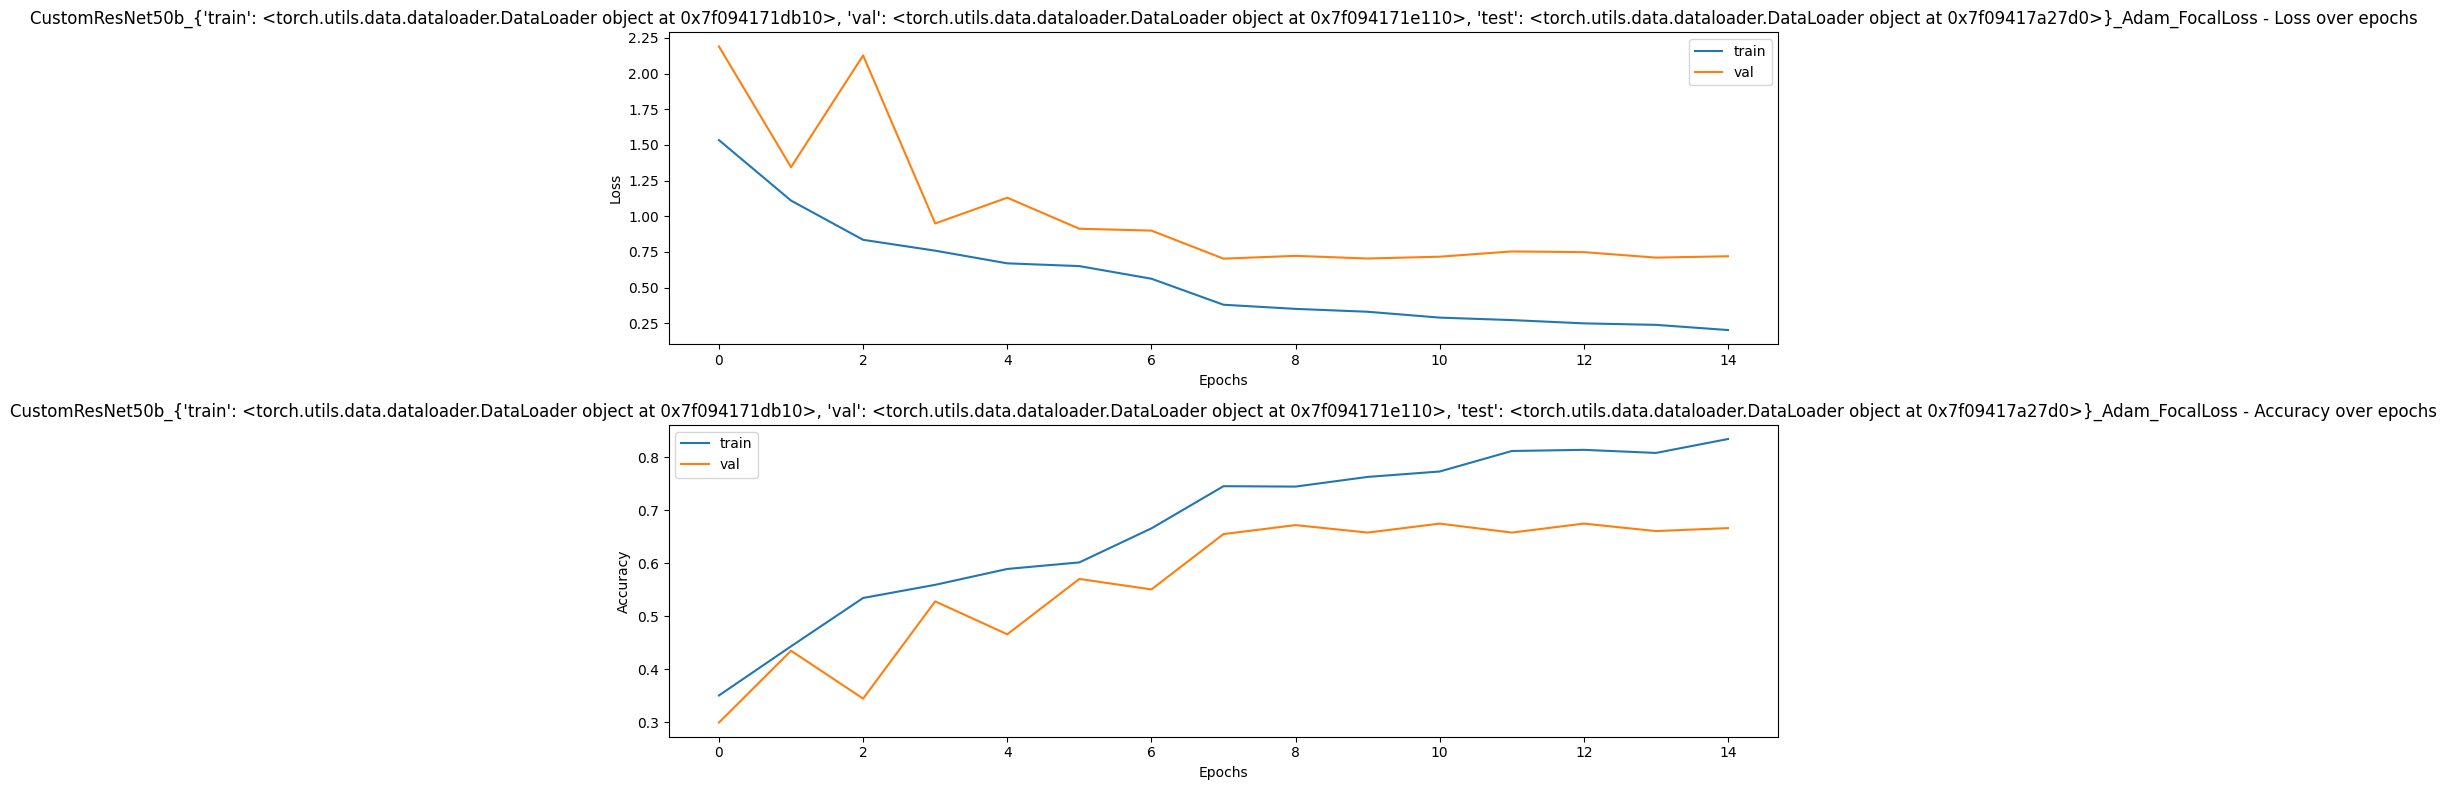

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f0948aa6440>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f0941499d20>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f0941562ce0>}, SGD, CrossEntropyLoss


100%|██████████| 30.8M/30.8M [00:00<00:00, 101MB/s] 


Epoch 0/14
----------
train Loss: 1.8847 Acc: 0.4456
val Loss: 1.1628 Acc: 0.6497

Epoch 1/14
----------
train Loss: 0.8371 Acc: 0.7692
val Loss: 0.8621 Acc: 0.7542

Epoch 2/14
----------
train Loss: 0.5104 Acc: 0.8678
val Loss: 0.7069 Acc: 0.7825

Epoch 3/14
----------
train Loss: 0.3575 Acc: 0.9072
val Loss: 0.6155 Acc: 0.8192

Epoch 4/14
----------
train Loss: 0.2495 Acc: 0.9364
val Loss: 0.6378 Acc: 0.8136

Epoch 5/14
----------
train Loss: 0.1726 Acc: 0.9620
val Loss: 0.5969 Acc: 0.8136

Epoch 6/14
----------
train Loss: 0.1121 Acc: 0.9803
val Loss: 0.6061 Acc: 0.8192

Epoch 7/14
----------
train Loss: 0.0938 Acc: 0.9905
val Loss: 0.5965 Acc: 0.8362

Epoch 8/14
----------
train Loss: 0.0872 Acc: 0.9898
val Loss: 0.6201 Acc: 0.8220

Epoch 9/14
----------
train Loss: 0.0913 Acc: 0.9876
val Loss: 0.5861 Acc: 0.8305

Epoch 10/14
----------
train Loss: 0.0847 Acc: 0.9905
val Loss: 0.5904 Acc: 0.8333

Epoch 11/14
----------
train Loss: 0.0766 Acc: 0.9949
val Loss: 0.5830 Acc: 0.8220

Ep

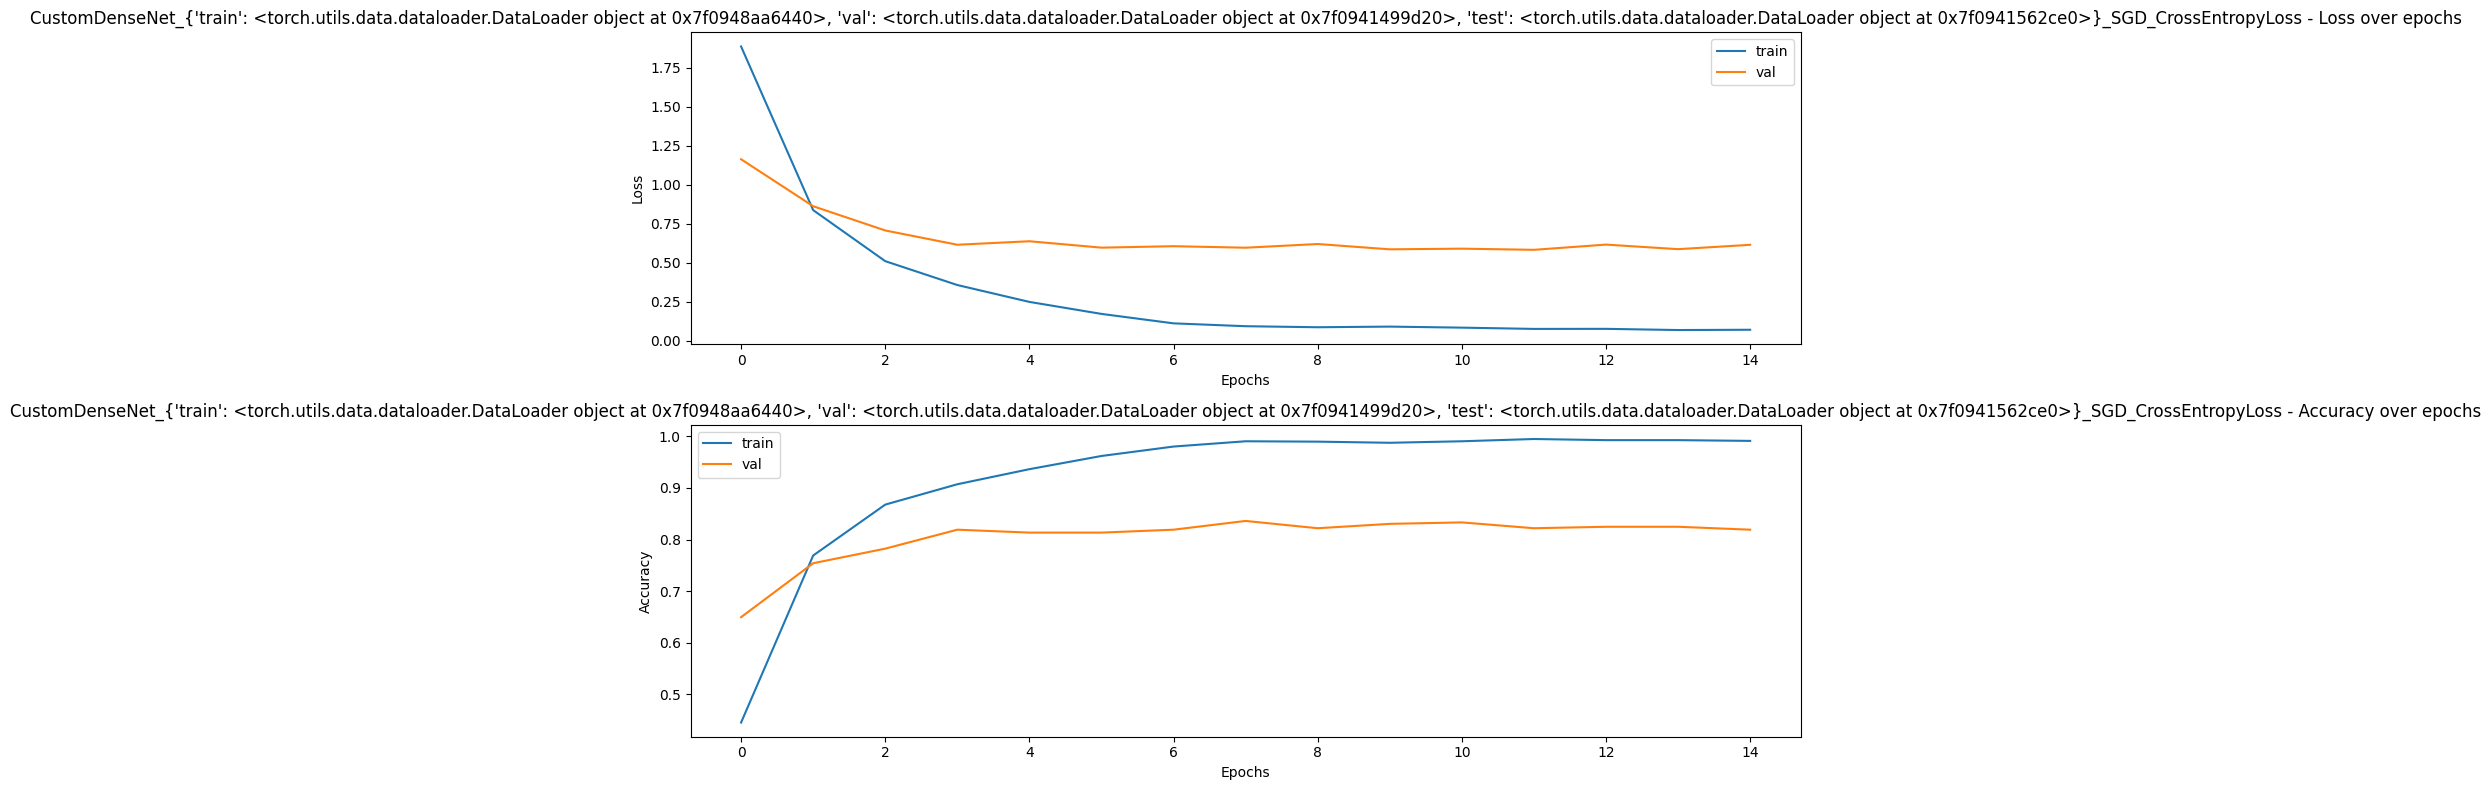


Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f0948aa6440>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f0941499d20>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f0941562ce0>}, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 1.3252 Acc: 0.5040
val Loss: 0.7765 Acc: 0.6610

Epoch 1/14
----------
train Loss: 0.4256 Acc: 0.8130
val Loss: 0.5098 Acc: 0.7571

Epoch 2/14
----------
train Loss: 0.2703 Acc: 0.8524
val Loss: 0.5580 Acc: 0.7373

Epoch 3/14
----------
train Loss: 0.1643 Acc: 0.9087
val Loss: 0.4208 Acc: 0.7994

Epoch 4/14
----------
train Loss: 0.0869 Acc: 0.9657
val Loss: 0.3925 Acc: 0.7910

Epoch 5/14
----------
train Loss: 0.0595 Acc: 0.9752
val Loss: 0.3961 Acc: 0.7938

Epoch 6/14
----------
train Loss: 0.0372 Acc: 0.9920
val Loss: 0.3815 Acc: 0.8164

Epoch 7/14
----------
train Loss: 0.0322 Acc: 0.9942
val Loss: 0.3699 Acc: 0.8107

Epoch 8/14
----------
train Loss: 0.0319 Acc: 0.9927
val Loss: 

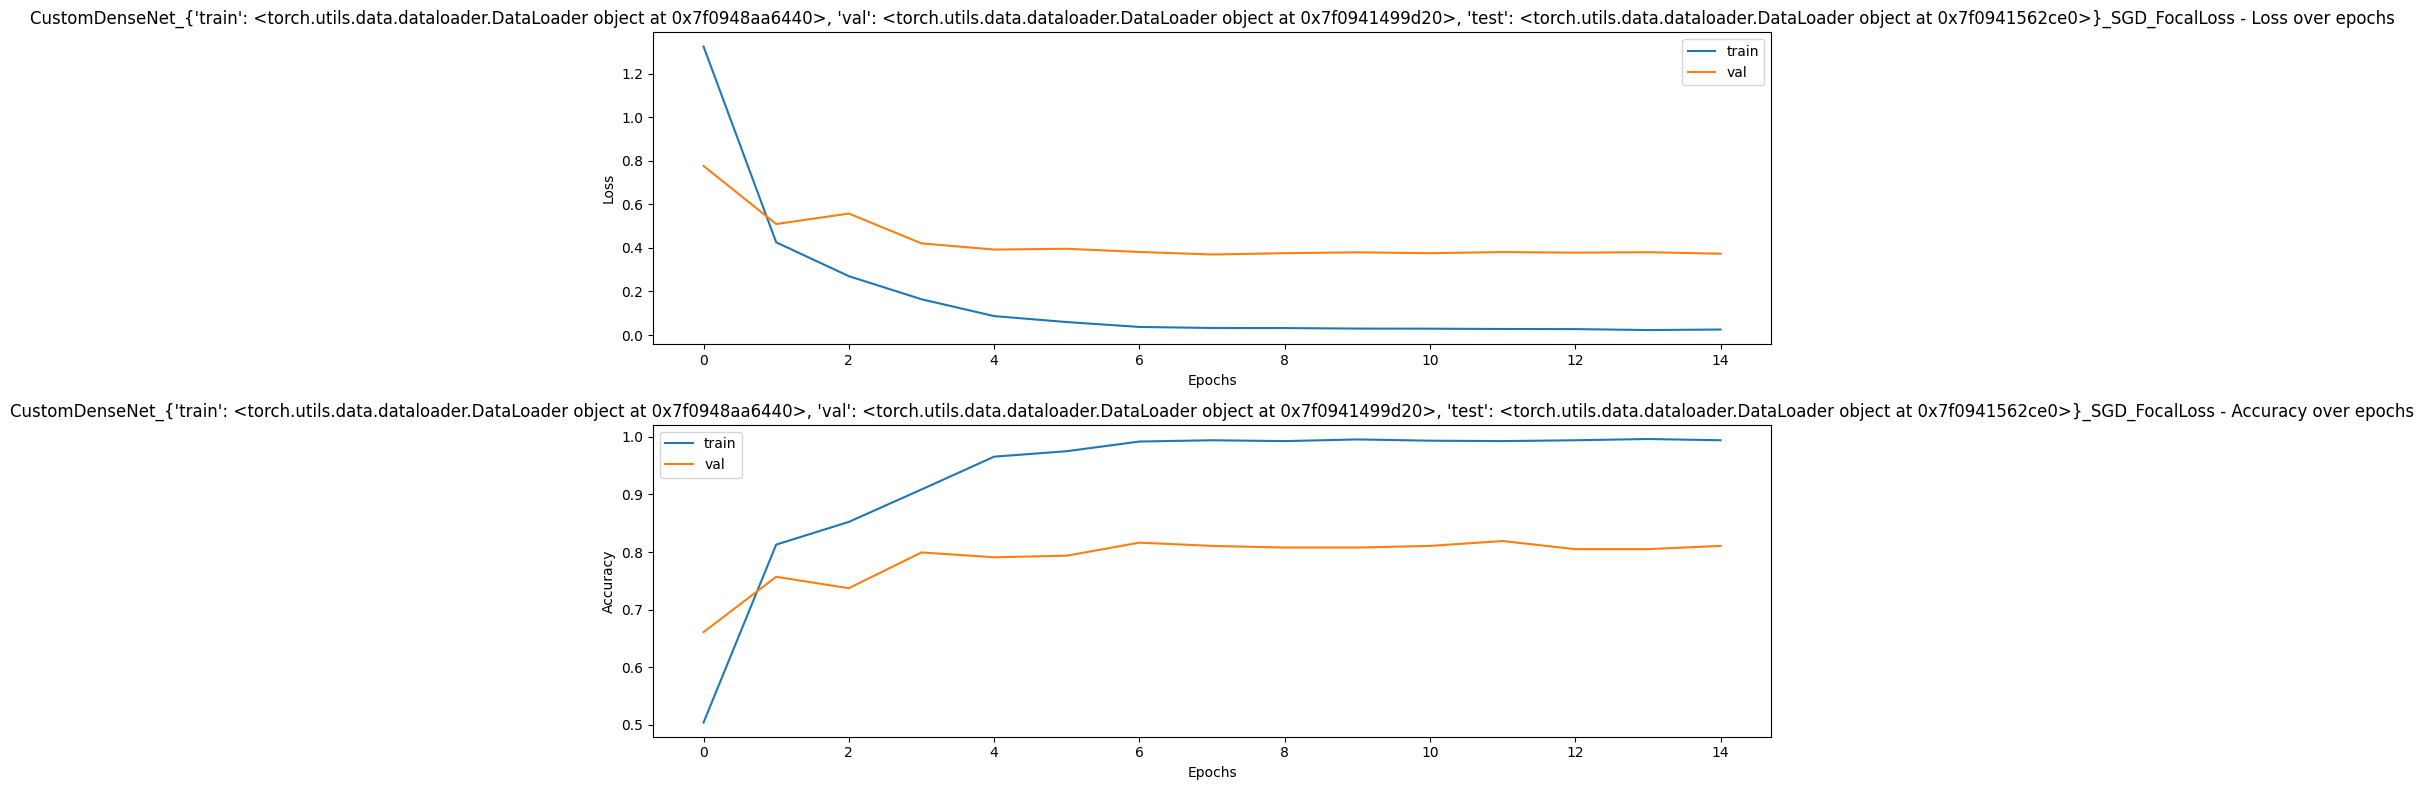


Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f0948aa6440>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f0941499d20>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f0941562ce0>}, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.3491 Acc: 0.5851
val Loss: 1.9205 Acc: 0.5311

Epoch 1/14
----------
train Loss: 0.8628 Acc: 0.7443
val Loss: 0.9166 Acc: 0.7119

Epoch 2/14
----------
train Loss: 0.6188 Acc: 0.8072
val Loss: 1.6075 Acc: 0.5960

Epoch 3/14
----------
train Loss: 0.5324 Acc: 0.8152
val Loss: 0.7599 Acc: 0.7712

Epoch 4/14
----------
train Loss: 0.4725 Acc: 0.8415
val Loss: 1.8998 Acc: 0.5876

Epoch 5/14
----------
train Loss: 0.4051 Acc: 0.8707
val Loss: 0.9809 Acc: 0.7288

Epoch 6/14
----------
train Loss: 0.3496 Acc: 0.8707
val Loss: 1.1608 Acc: 0.7627

Epoch 7/14
----------
train Loss: 0.2202 Acc: 0.9270
val Loss: 0.4887 Acc: 0.8418

Epoch 8/14
----------
train Loss: 0.1381 Acc: 0.9635
va

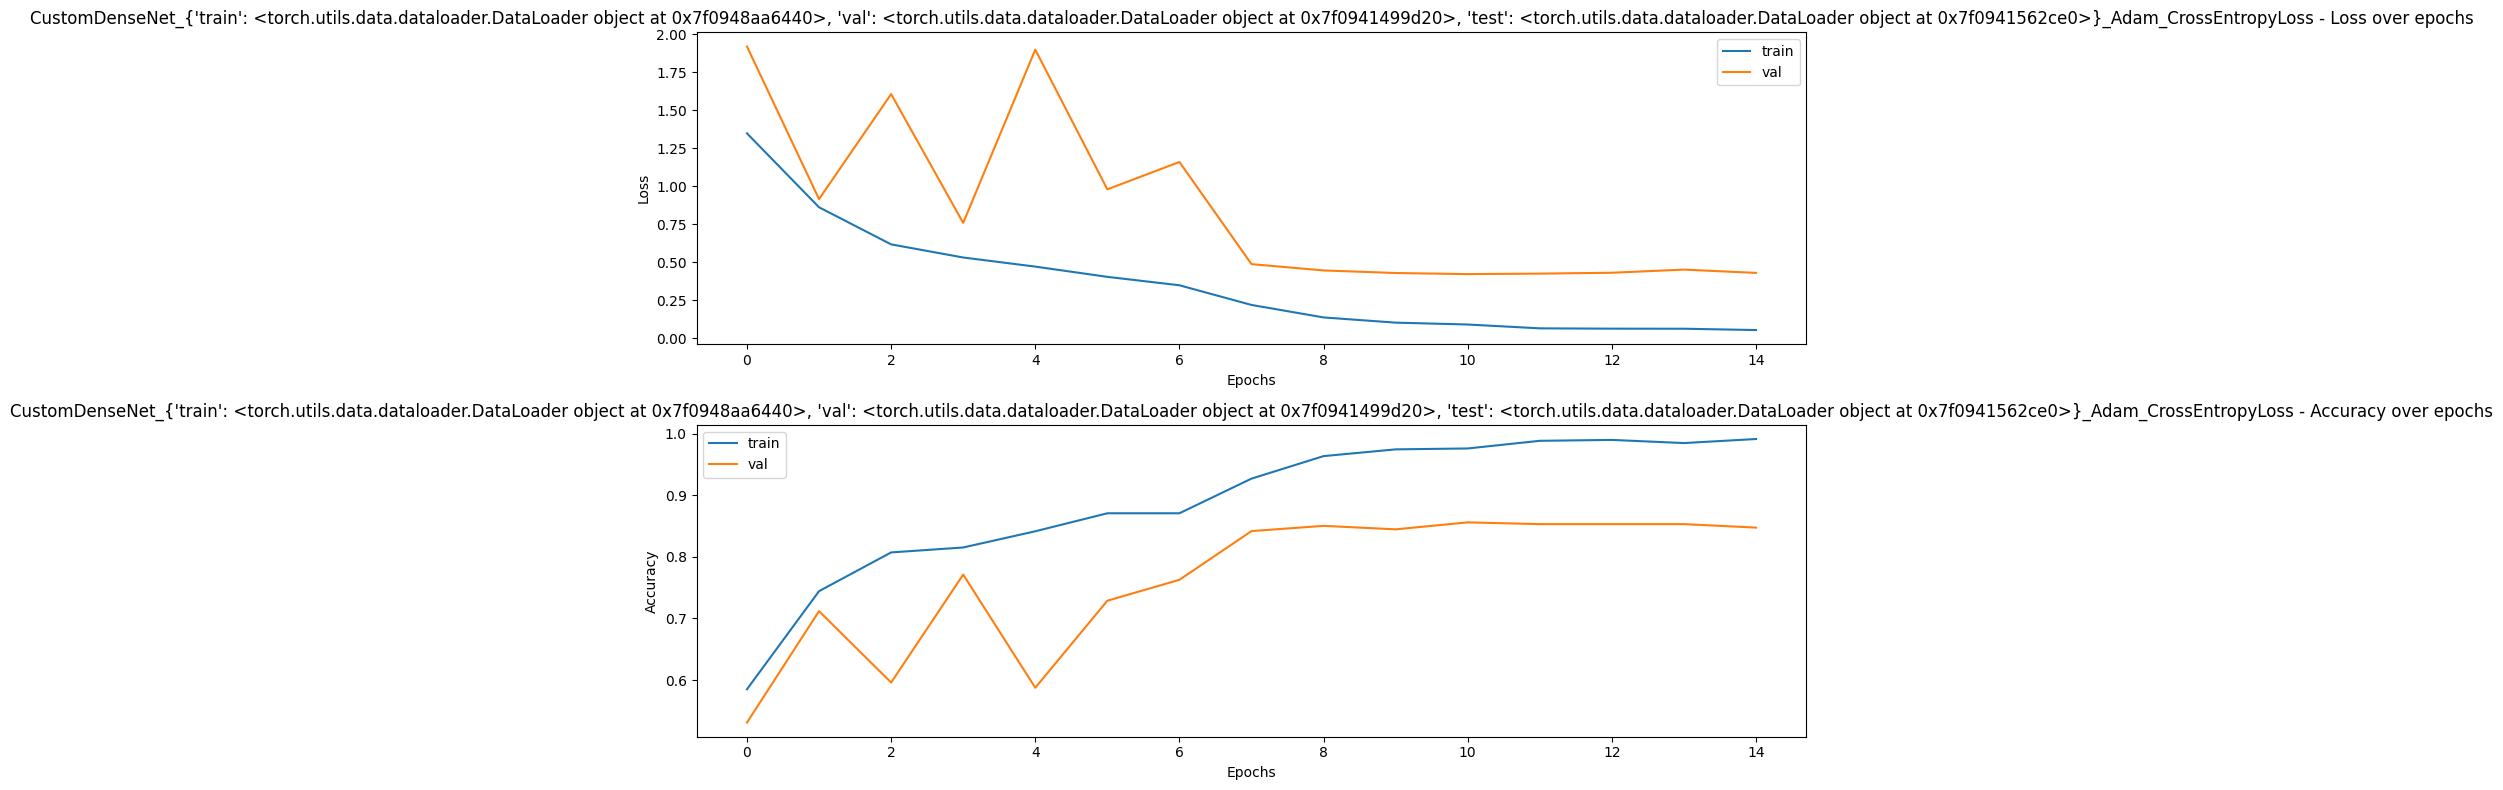


Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f0948aa6440>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f0941499d20>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f0941562ce0>}, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 0.9214 Acc: 0.5895
val Loss: 0.9194 Acc: 0.5989

Epoch 1/14
----------
train Loss: 0.5140 Acc: 0.7334
val Loss: 0.7003 Acc: 0.6469

Epoch 2/14
----------
train Loss: 0.3397 Acc: 0.8064
val Loss: 0.5482 Acc: 0.6836

Epoch 3/14
----------
train Loss: 0.2773 Acc: 0.8188
val Loss: 0.5181 Acc: 0.7401

Epoch 4/14
----------
train Loss: 0.2834 Acc: 0.8262
val Loss: 0.5131 Acc: 0.7712

Epoch 5/14
----------
train Loss: 0.2014 Acc: 0.8532
val Loss: 0.8247 Acc: 0.7175

Epoch 6/14
----------
train Loss: 0.1637 Acc: 0.8809
val Loss: 0.3913 Acc: 0.8220

Epoch 7/14
----------
train Loss: 0.0658 Acc: 0.9496
val Loss: 0.2996 Acc: 0.8503

Epoch 8/14
----------
train Loss: 0.0395 Acc: 0.9701
val Loss:

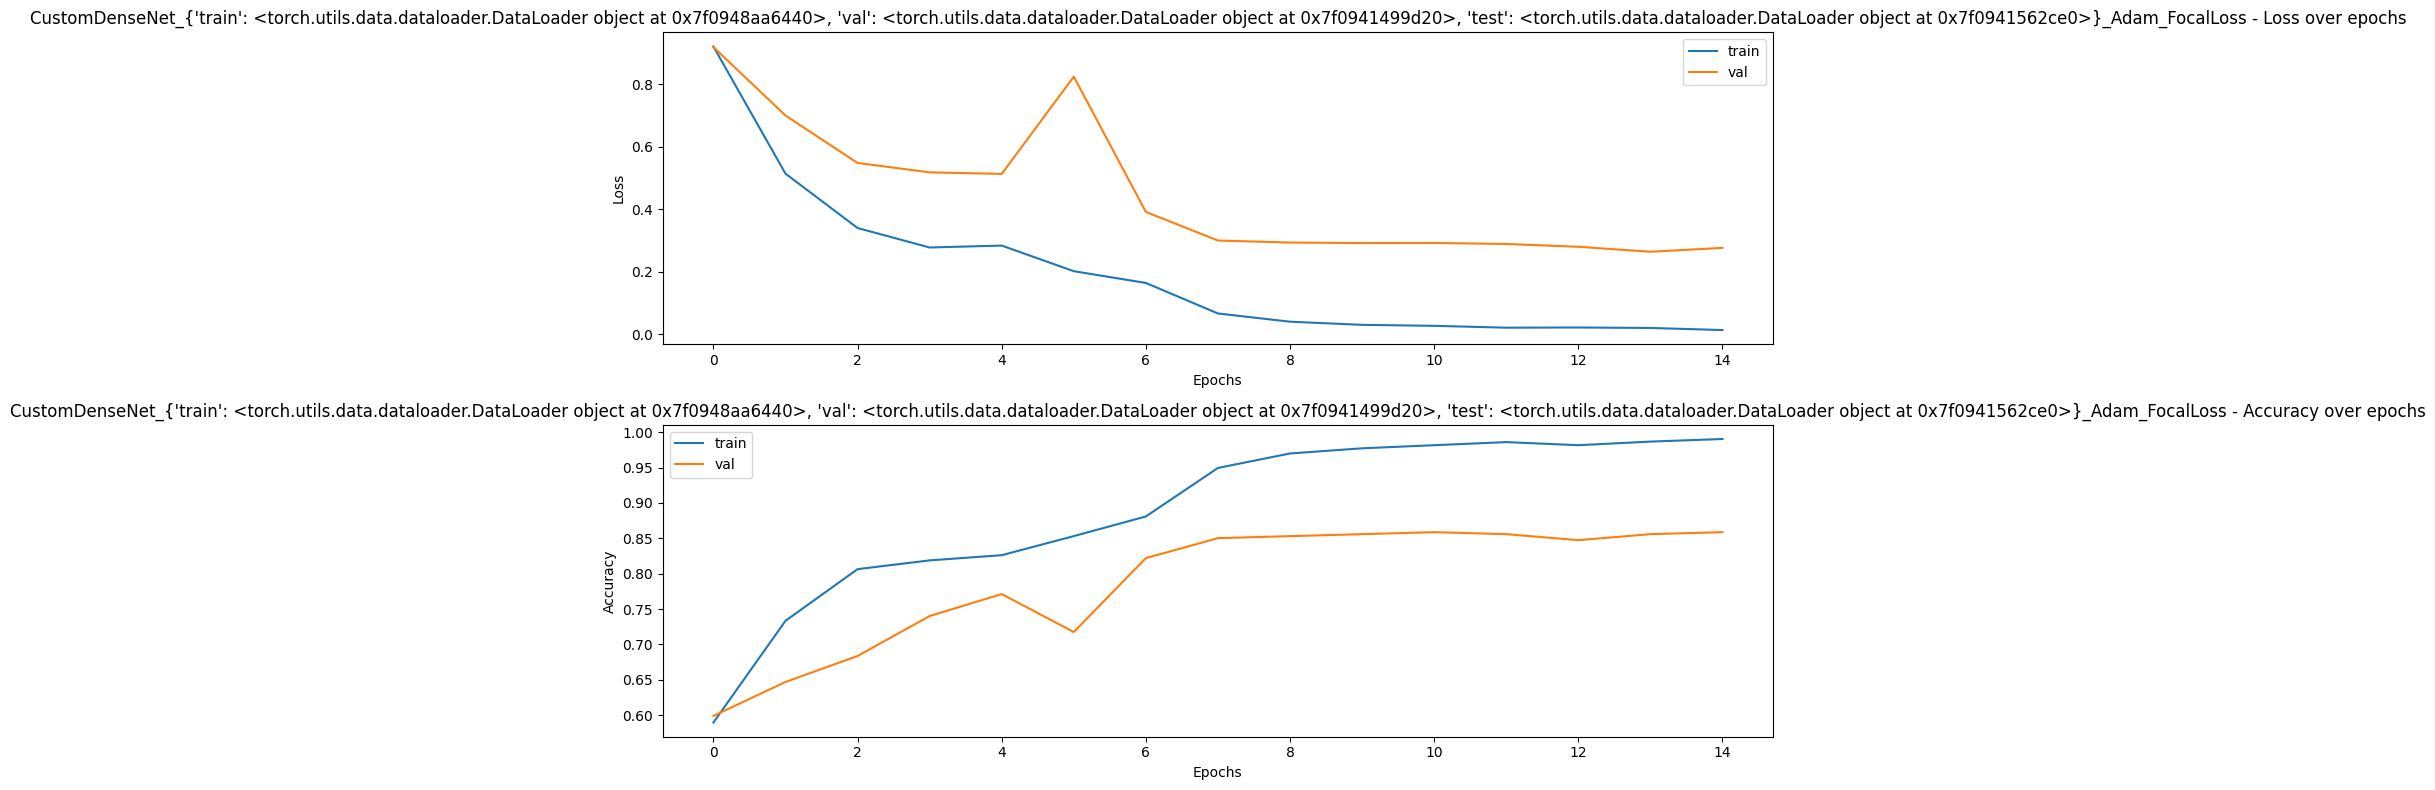


Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f094171db10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f094171e110>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f09417a27d0>}, SGD, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.8230 Acc: 0.4617
val Loss: 1.1189 Acc: 0.6977

Epoch 1/14
----------
train Loss: 0.8418 Acc: 0.7721
val Loss: 0.8682 Acc: 0.7684

Epoch 2/14
----------
train Loss: 0.5325 Acc: 0.8510
val Loss: 0.6871 Acc: 0.8136

Epoch 3/14
----------
train Loss: 0.3710 Acc: 0.9050
val Loss: 0.6396 Acc: 0.7994

Epoch 4/14
----------
train Loss: 0.2492 Acc: 0.9372
val Loss: 0.5845 Acc: 0.8305

Epoch 5/14
----------
train Loss: 0.1835 Acc: 0.9649
val Loss: 0.5417 Acc: 0.8277

Epoch 6/14
----------
train Loss: 0.1268 Acc: 0.9817
val Loss: 0.5494 Acc: 0.8446

Epoch 7/14
----------
train Loss: 0.0987 Acc: 0.9883
val Loss: 0.5365 Acc: 0.8475

Epoch 8/14
----------
train Loss: 0.0826 Acc: 0.9905
val

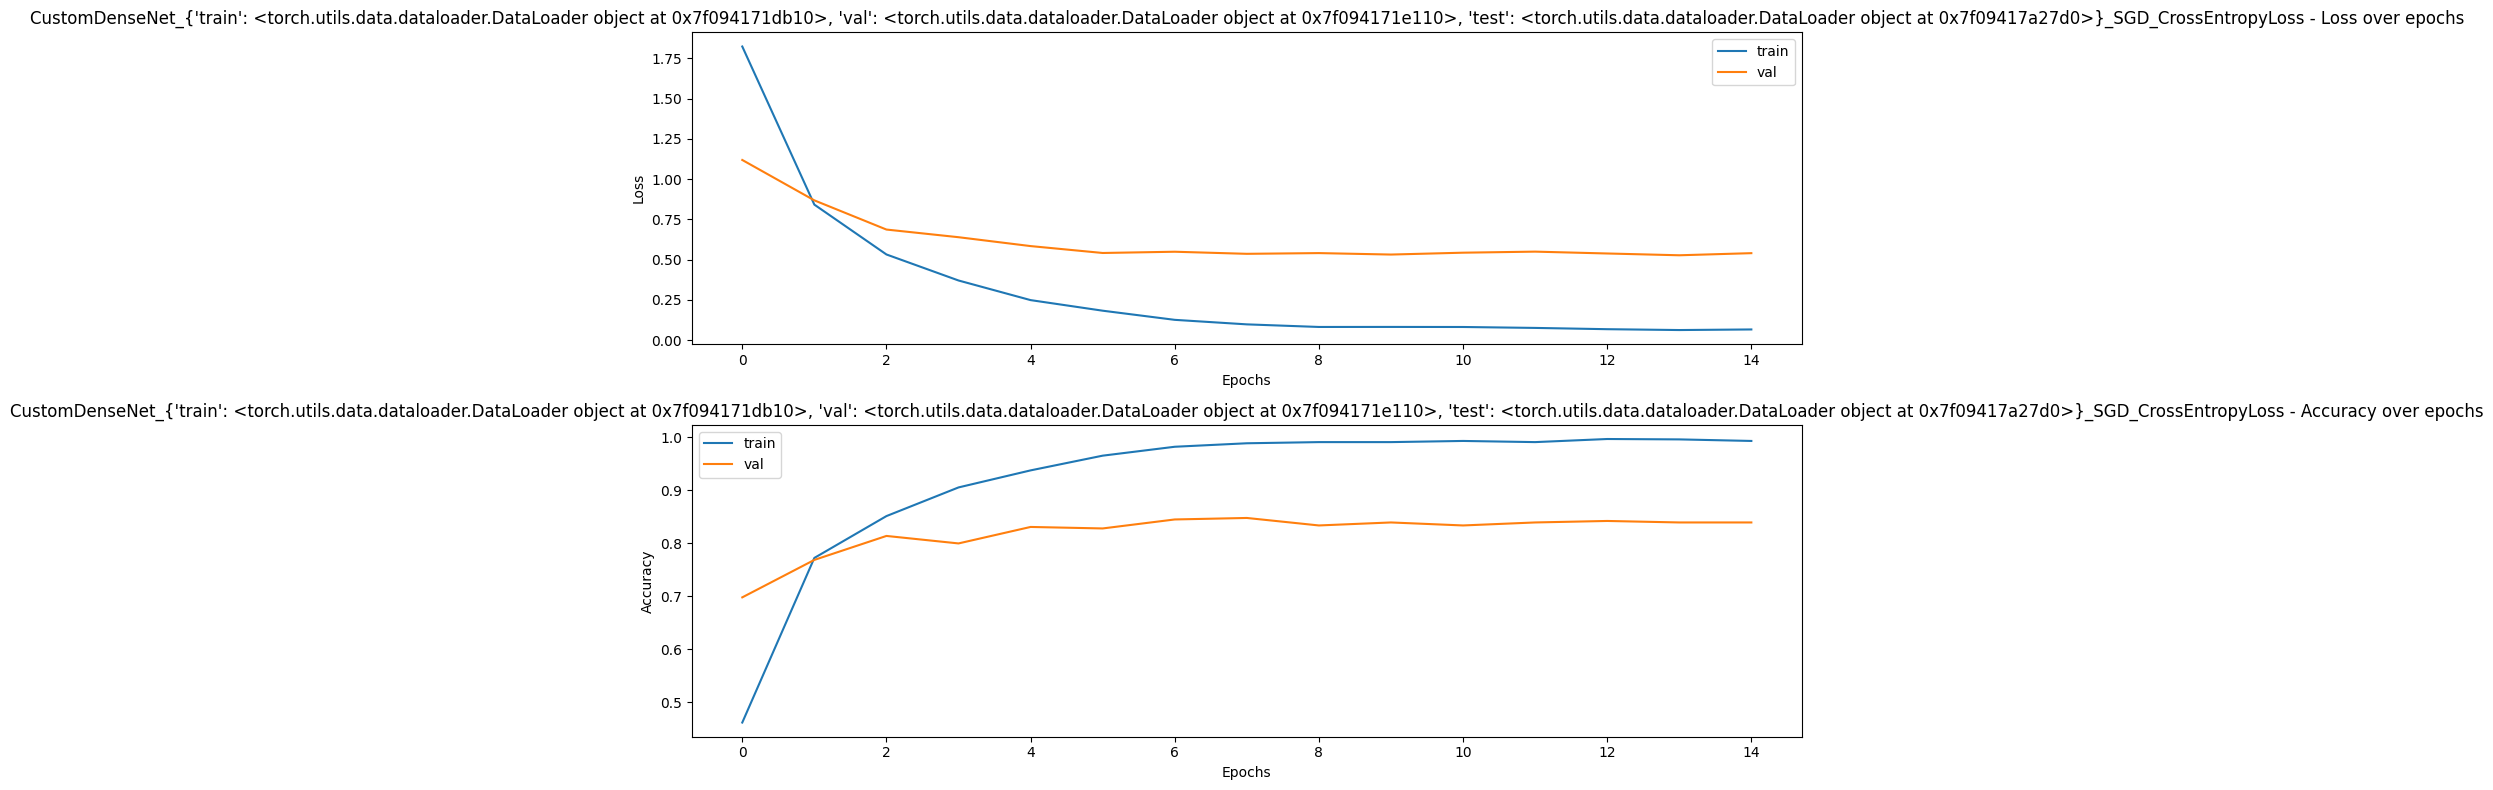


Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f094171db10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f094171e110>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f09417a27d0>}, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 1.3408 Acc: 0.4792
val Loss: 0.7138 Acc: 0.6723

Epoch 1/14
----------
train Loss: 0.4577 Acc: 0.7874
val Loss: 0.5192 Acc: 0.7458

Epoch 2/14
----------
train Loss: 0.2503 Acc: 0.8751
val Loss: 0.4626 Acc: 0.7486

Epoch 3/14
----------
train Loss: 0.1470 Acc: 0.9233
val Loss: 0.3892 Acc: 0.7684

Epoch 4/14
----------
train Loss: 0.0865 Acc: 0.9584
val Loss: 0.3553 Acc: 0.8079

Epoch 5/14
----------
train Loss: 0.0614 Acc: 0.9766
val Loss: 0.3696 Acc: 0.7938

Epoch 6/14
----------
train Loss: 0.0452 Acc: 0.9839
val Loss: 0.3670 Acc: 0.7910

Epoch 7/14
----------
train Loss: 0.0349 Acc: 0.9890
val Loss: 0.3372 Acc: 0.8023

Epoch 8/14
----------
train Loss: 0.0312 Acc: 0.9927
val Loss: 

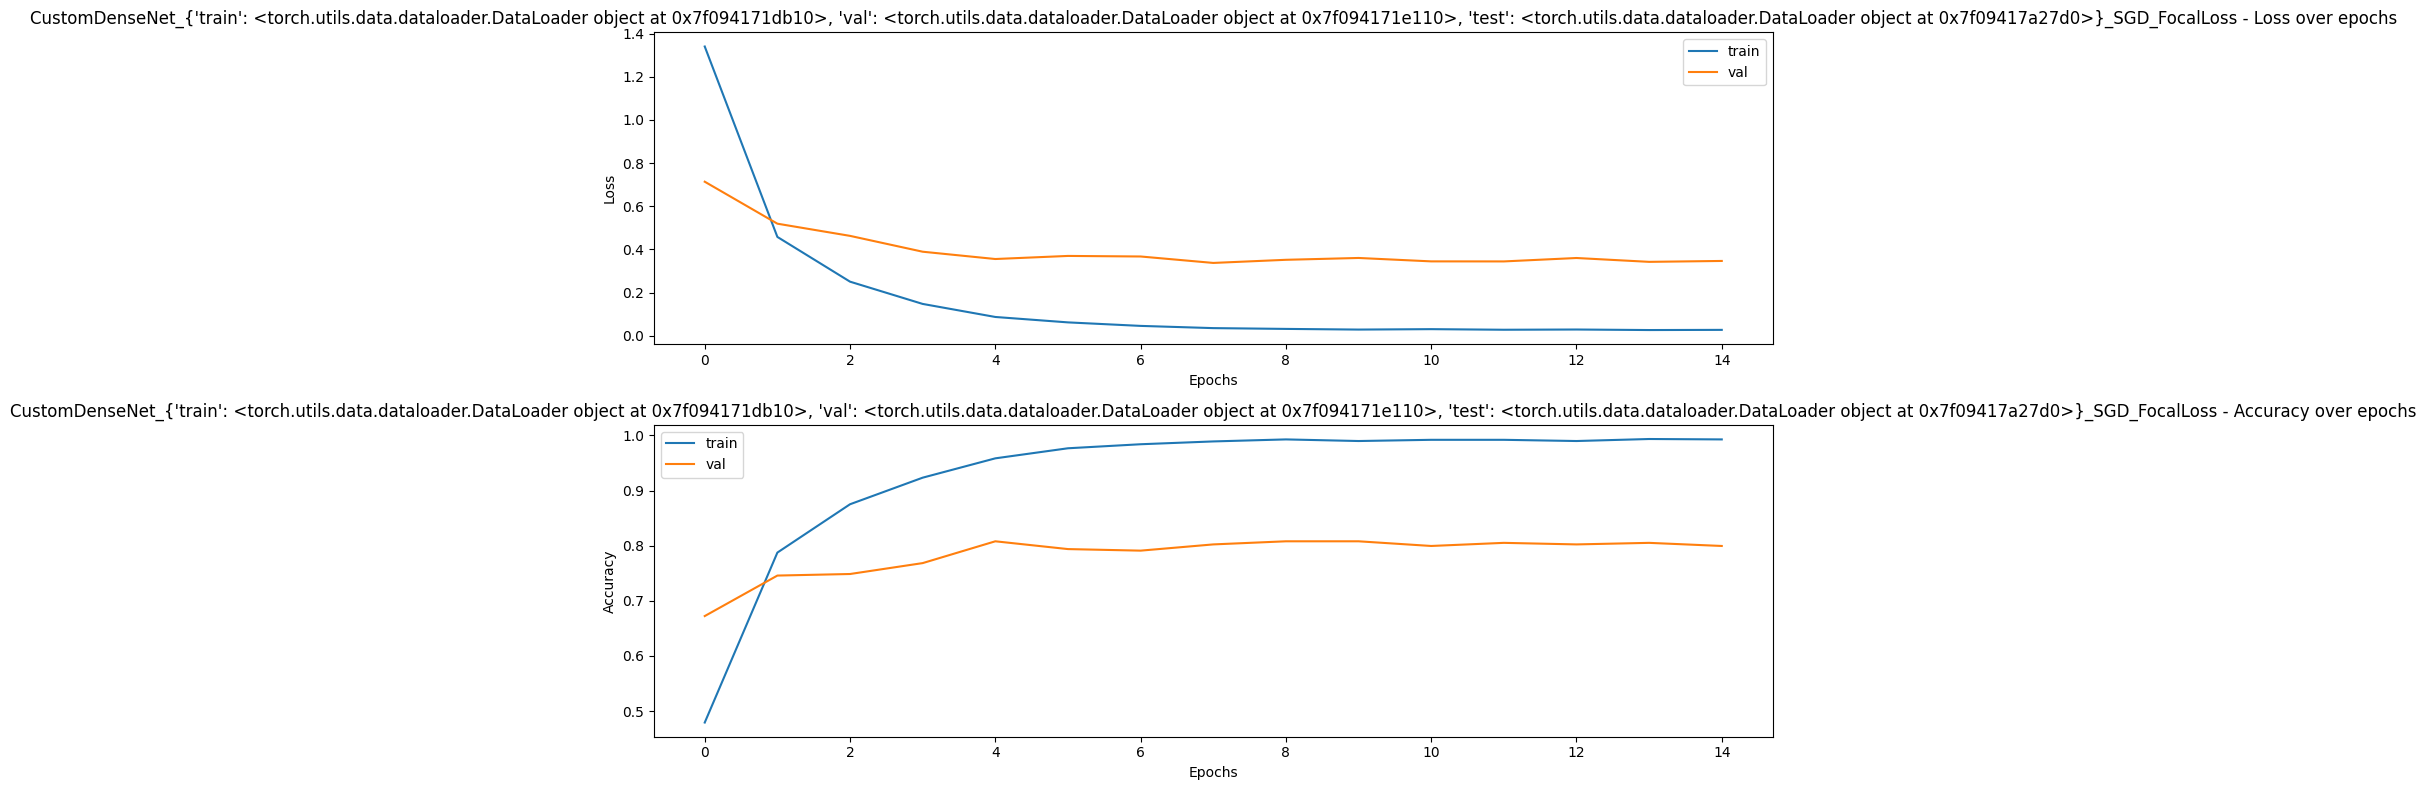


Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f094171db10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f094171e110>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f09417a27d0>}, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.4072 Acc: 0.5763
val Loss: 1.4227 Acc: 0.5706

Epoch 1/14
----------
train Loss: 0.8003 Acc: 0.7495
val Loss: 1.0556 Acc: 0.6525

Epoch 2/14
----------
train Loss: 0.6185 Acc: 0.7904
val Loss: 0.8274 Acc: 0.7740

Epoch 3/14
----------
train Loss: 0.5266 Acc: 0.8232
val Loss: 1.1134 Acc: 0.6836

Epoch 4/14
----------
train Loss: 0.4518 Acc: 0.8517
val Loss: 0.8849 Acc: 0.7316

Epoch 5/14
----------
train Loss: 0.3189 Acc: 0.8890
val Loss: 1.6262 Acc: 0.6751

Epoch 6/14
----------
train Loss: 0.3346 Acc: 0.8919
val Loss: 1.3854 Acc: 0.6864

Epoch 7/14
----------
train Loss: 0.1728 Acc: 0.9489
val Loss: 0.4973 Acc: 0.8333

Epoch 8/14
----------
train Loss: 0.1135 Acc: 0.9657
va

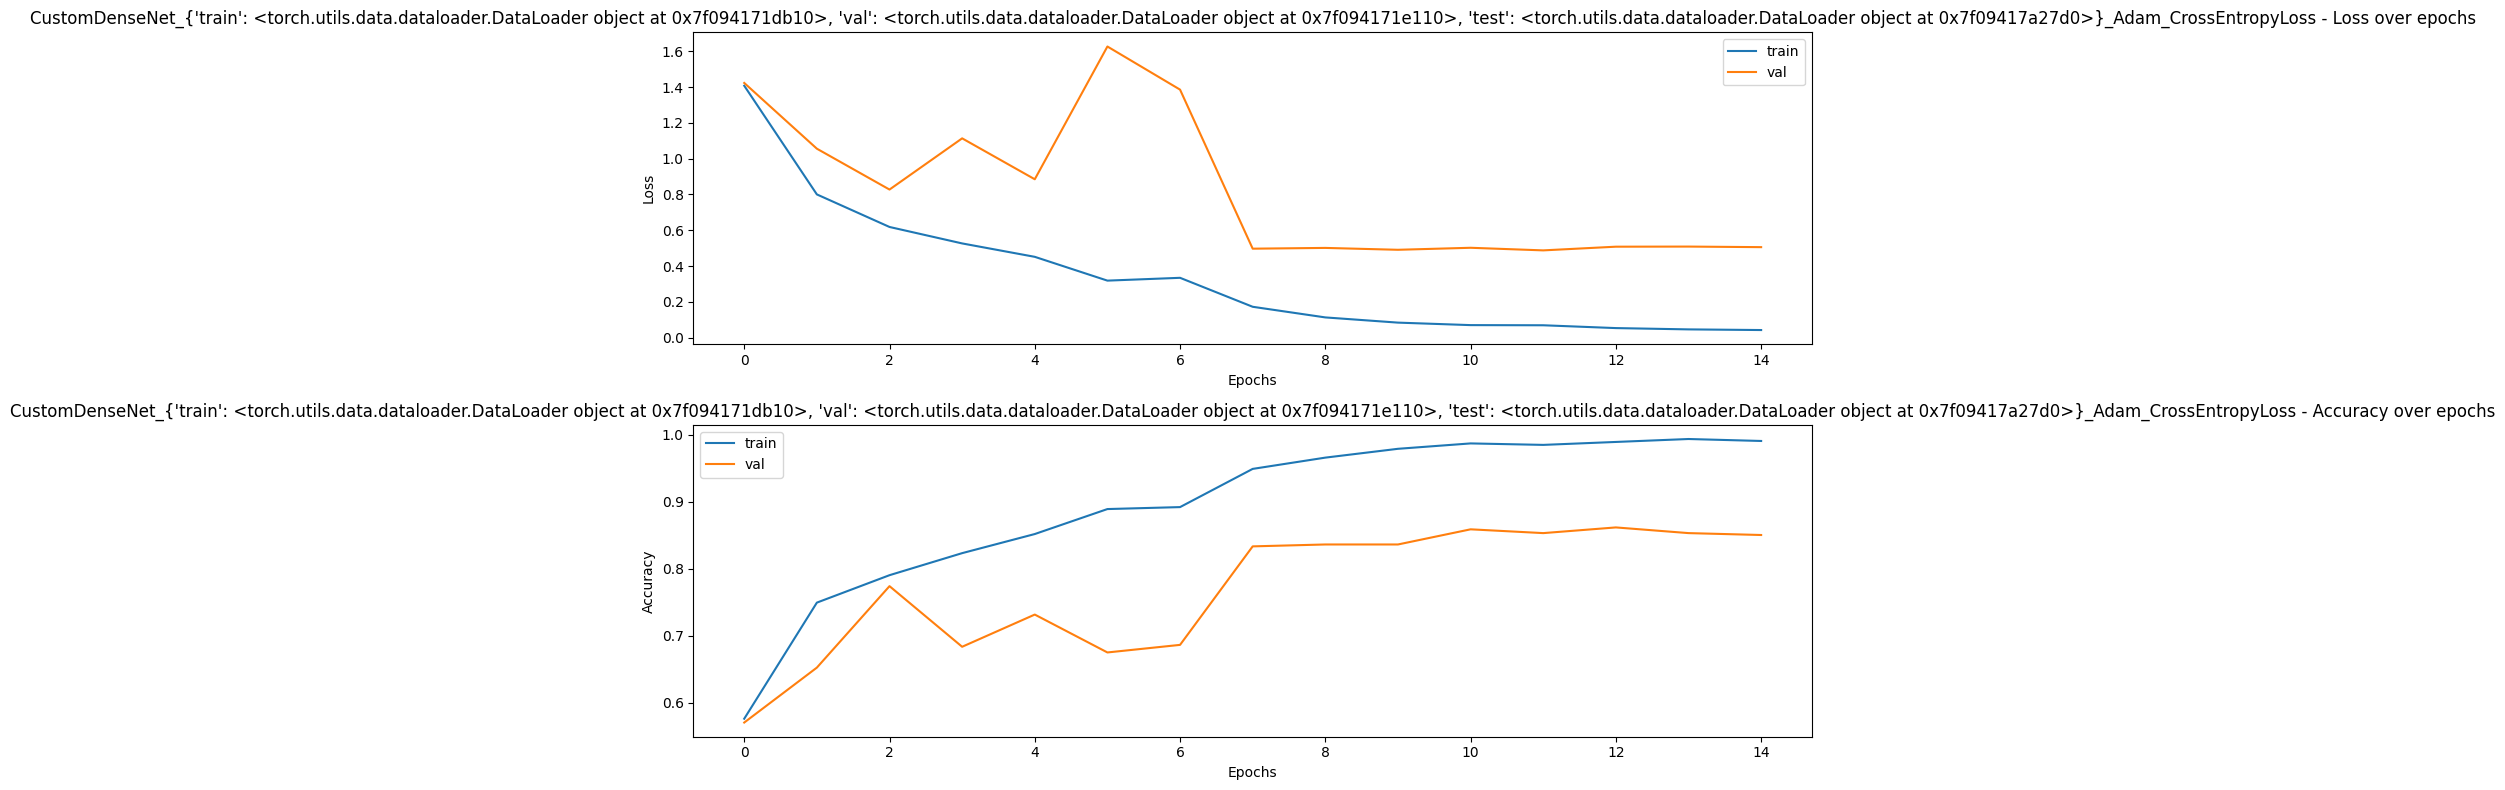


Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f094171db10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f094171e110>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f09417a27d0>}, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 0.9426 Acc: 0.5690
val Loss: 1.6255 Acc: 0.4322

Epoch 1/14
----------
train Loss: 0.5321 Acc: 0.7159
val Loss: 0.9814 Acc: 0.5763

Epoch 2/14
----------
train Loss: 0.4238 Acc: 0.7480
val Loss: 0.8125 Acc: 0.6243

Epoch 3/14
----------
train Loss: 0.2737 Acc: 0.8408
val Loss: 0.7171 Acc: 0.6864

Epoch 4/14
----------
train Loss: 0.2315 Acc: 0.8364
val Loss: 0.6955 Acc: 0.7203

Epoch 5/14
----------
train Loss: 0.1794 Acc: 0.8802
val Loss: 0.8479 Acc: 0.6469

Epoch 6/14
----------
train Loss: 0.2084 Acc: 0.8524
val Loss: 1.9782 Acc: 0.4859

Epoch 7/14
----------
train Loss: 0.0997 Acc: 0.9218
val Loss: 0.3150 Acc: 0.8362

Epoch 8/14
----------
train Loss: 0.0485 Acc: 0.9613
val Loss:

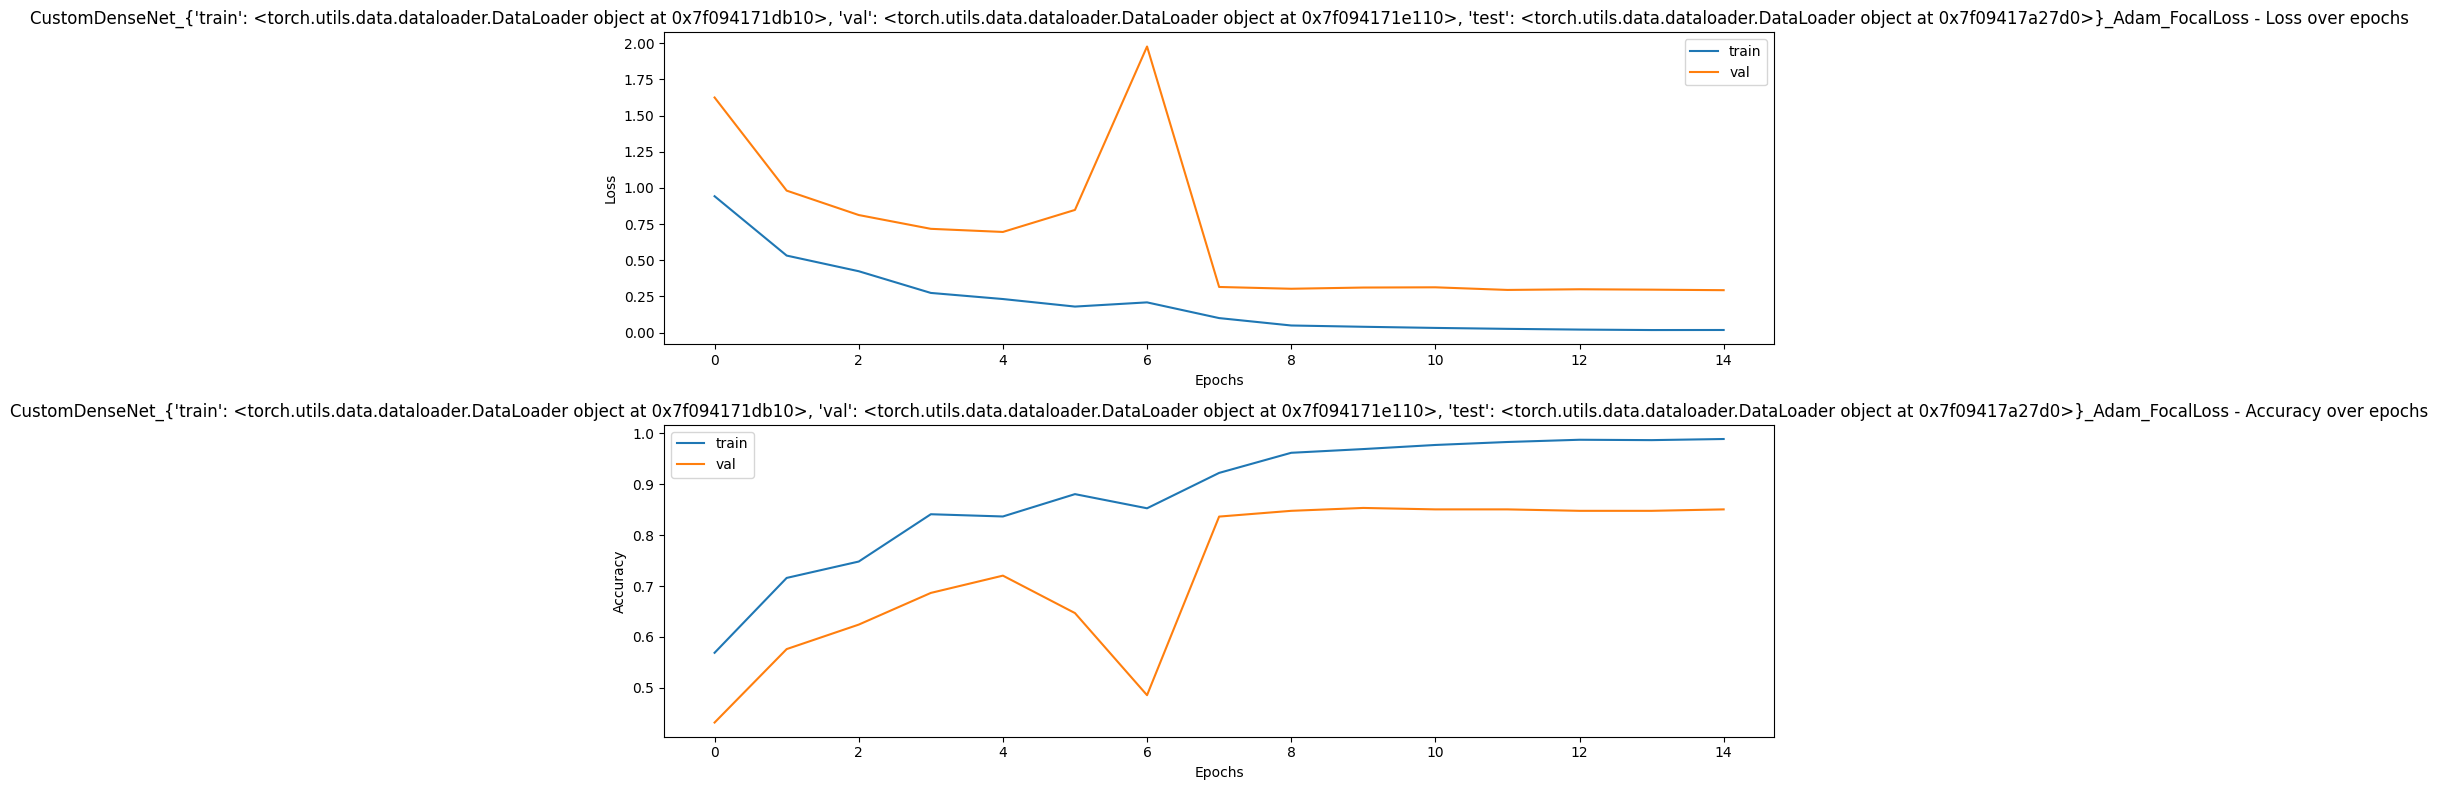

In [16]:
# perform several training runs to compare accuracy on the validation dataset

for model_class in models:
  for loader in loaders:
        for opt in optimizers:
            for loss_func_class in loss_funcs:
                print(f"\nTraining with {model_class.__name__}, {loader}, {opt}, {loss_func_class.__name__}")

                # Instantiate the custom model
                num_classes = len(classes)
                model = model_class(num_classes)
                model = model.to(device)  # Move the model to the appropriate device

                # Define loss function 
                criterion = loss_func_class()
               
                # Instantiate the selected optimizer with its parameters
                opt_class = optim_dict[opt]['class']
                opt_params = optim_dict[opt]['params']
                optimizer = opt_class(model.parameters(), **opt_params)
               
                #optimizer = opt_class(model.parameters(), lr=0.001, momentum=0.9)

                # Decay LR by a factor of 0.1 every 7 epochs
                exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

                # Train the model
                trained_model, best_val_accuracy, history = train_cnn_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

                # Print the history data
                print("Training loss history:", history['train_loss'])
                print("Validation loss history:", history['val_loss'])
                print("Training accuracy history:", history['train_acc'])
                print("Validation accuracy history:", history['val_acc'])


                # Plot training curves
                combination_name = f"{model_class.__name__}_{loader}_{opt}_{loss_func_class.__name__}"
                plot_training_curves(history, combination_name)

               

In [ ]:
def display_and_save_results2(y_pred, y_true, classes=classes, fn='', saveflag = True):
   

    classes_raw_list = np.unique(np.concatenate((y_true, y_pred)))
    print(classes_raw_list)
    classes_list = [classes[x] for x in classes_raw_list]
    print(classes_list)
    y_true = [classes[x] for x in y_true]
    y_pred = [classes[x] for x in y_pred]
    # Generate a confusion matrix based on the true labels and predicted labels
    cm = confusion_matrix(y_true = y_true, y_pred = y_pred, labels=classes_list)
  
    #mask = np.all(cm == 0, axis=1)

    class_text_labels = np.array([abd_label_dict[str(x)]['short'] for x in classes_list])
    #class_text_labels = class_text_labels[~mask]

     # Generate a classification report based on the true labels and predicted labels
    print(classification_report(y_true, y_pred))

    
    #cm = cm[~mask]
    # Create a ConfusionMatrixDisplay object with the correct labels
    cm_display = ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    plt.figure(figsize=(25, 25))
    plt.tight_layout()
    #ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    if saveflag:
        plt.savefig("../assets/FigCM_"+fn+datetime.today().strftime('%Y%m%d')+".tif",dpi=300, bbox_inches = 'tight')     

    return cm      



In [ ]:
# Evaluate the model on the val dataset

model.eval()
val_predictions = []
val_labels = []

for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad(): # No need to calculate gradients when doing inference
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) # Get class from network's prediction
        val_predictions.append(predicted.cpu().numpy())
        val_labels.append(labels.cpu().numpy())
val_predictions = np.concatenate(val_predictions, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

#print(val_predictions)
#print(val_labels)
cm = display_and_save_results2(val_predictions, val_labels, classes, fn='DenseNetFL', saveflag=True)

# Save the trained model if needed
save_filename = f"cnn_model_{combination_name}_{datetime.now().strftime('%Y%m%d')}.pth"
torch.save(trained_model.state_dict(), save_filename)



# model.eval()
# val_predictions = []
# test_labels = []

# for inputs, labels in test_loader:
#     inputs = inputs.to(device)
#     labels = labels.to(device)
#     print(labels)
#     with torch.no_grad(): # No need to calculate gradients when doing inference
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1) # Get class from network's prediction
#         test_predictions.append(predicted.cpu().numpy())
#         test_labels.append(labels.cpu().numpy())

# print (test_predictions)
# print(test_labels)


# test_predictions = np.concatenate(test_predictions, axis=0)
# test_labels = np.concatenate(test_labels, axis=0)


# accuracy = np.sum(test_predictions==test_labels)/len(test_labels)
# print('Accuracy on the test dataset is ', np.round(accuracy, 3))
# #results = make_results_df(preds, true, test)

# # Save the trained model if needed
# save_filename = f"cnn_model_{combination_name}_{datetime.now().strftime('%Y%m%d')}.pth"
# torch.save(trained_model.state_dict(), save_filename)
